In [4]:
import warnings

# 屏蔽所有警告（不推荐，可能隐藏重要信息）
warnings.filterwarnings("ignore")

In [5]:
# 数据清洗模块 - 添加到notebook开头的数据预处理部分

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import shutil

class DataCleaner:
    def __init__(self, device=None):
        """初始化数据清洗器"""
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device
            
        # 加载预训练模型用于特征提取
        self.model = models.resnet50(pretrained=True)
        # 去掉最后的全连接层，只保留特征提取部分
        self.model = torch.nn.Sequential(*list(self.model.children())[:-1])
        self.model.eval()
        self.model.to(self.device)
        
        # 图像预处理
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    class MedicineImageDataset(Dataset):
        """自定义数据集类，用于加载图像和路径"""
        def __init__(self, folder_path, transform=None):
            self.folder_path = folder_path
            self.transform = transform
            self.image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) 
                               if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
            
        def __len__(self):
            return len(self.image_paths)
        
        def __getitem__(self, idx):
            img_path = self.image_paths[idx]
            try:
                image = Image.open(img_path).convert('RGB')
                if self.transform:
                    image = self.transform(image)
                return image, img_path
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                # 返回一个占位图像
                dummy_image = torch.zeros(3, 224, 224)
                return dummy_image, img_path
    
    def extract_features(self, folder_path):
        """提取文件夹中所有图像的特征向量"""
        dataset = self.MedicineImageDataset(folder_path, self.transform)
        if len(dataset) == 0:
            print(f"警告: {folder_path} 中没有找到图像文件")
            return np.array([]), []
            
        dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=4)
        
        features = []
        paths = []
        
        with torch.no_grad():
            for images, img_paths in tqdm(dataloader, desc=f"提取特征 - {os.path.basename(folder_path)}"):
                images = images.to(self.device)
                output = self.model(images)
                output = output.squeeze()
                # 处理单张图像的情况
                if output.dim() == 1:
                    output = output.unsqueeze(0)
                features.append(output.cpu().numpy())
                paths.extend(img_paths)
        
        if len(features) > 0:
            features = np.vstack(features)
        else:
            features = np.array([])
            
        return features, paths
    
    def clean_class_folder(self, class_folder, outliers_folder=None, num_outliers=10, move_files=True):
        """
        清洗一个类别文件夹中的异常图像
        
        参数:
            class_folder: 类别文件夹路径
            outliers_folder: 存放异常图像的输出文件夹，如果为None则只返回异常图像路径不移动
            num_outliers: 要识别的异常图像数量
            move_files: 是否移动文件，如果为False则只返回异常图像路径
        
        返回:
            outlier_paths: 识别出的异常图像路径列表
        """
        print(f"处理文件夹: {class_folder}")
        
        # 提取特征
        features, image_paths = self.extract_features(class_folder)
        
        if len(features) <= num_outliers:
            print(f"警告: {class_folder} 中的图像数量 ({len(features)}) 少于要识别的异常数量 ({num_outliers})")
            return []
        
        # 计算余弦相似度矩阵
        similarity_matrix = cosine_similarity(features)
        
        # 对每个样本，计算与其他所有样本的平均相似度
        avg_similarities = np.mean(similarity_matrix, axis=1)
        
        # 找出相似度最低的样本索引
        outlier_indices = np.argsort(avg_similarities)[:num_outliers]
        
        # 获取异常图像路径
        outlier_paths = [image_paths[idx] for idx in outlier_indices]
        
        # 如果需要移动文件且指定了输出文件夹
        if move_files and outliers_folder:
            # 确保输出文件夹存在
            os.makedirs(outliers_folder, exist_ok=True)
            
            class_name = os.path.basename(class_folder)
            for img_path in outlier_paths:
                img_name = os.path.basename(img_path)
                dst_path = os.path.join(outliers_folder, f"{class_name}_{img_name}")
                shutil.move(img_path, dst_path)
                print(f"已移动异常图像: {img_path} -> {dst_path}")
        
        return outlier_paths
    
    def clean_all_classes(self, root_folder, outliers_folder=None, num_outliers=10, move_files=True):
        """
        清洗所有类别文件夹中的异常图像
        
        参数:
            root_folder: 包含所有类别子文件夹的根目录
            outliers_folder: 存放所有异常图像的输出文件夹
            num_outliers: 每个类别要识别的异常图像数量
            move_files: 是否移动文件，如果为False则只返回异常图像路径
        
        返回:
            all_outliers: 字典，键为类别名称，值为该类别中识别出的异常图像路径列表
        """
        # 如果需要移动文件且指定了输出文件夹
        if move_files and outliers_folder:
            os.makedirs(outliers_folder, exist_ok=True)
        
        # 获取所有类别文件夹
        class_folders = [os.path.join(root_folder, d) for d in os.listdir(root_folder) 
                        if os.path.isdir(os.path.join(root_folder, d))]
        
        all_outliers = {}
        for class_folder in class_folders:
            class_name = os.path.basename(class_folder)
            outlier_paths = self.clean_class_folder(
                class_folder, outliers_folder, num_outliers, move_files
            )
            all_outliers[class_name] = outlier_paths
        
        return all_outliers

In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision import models, transforms
import pandas as pd
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

# --- 数据清洗模块：使用对比学习识别并移除异常图像 ---
print("=" * 50)
print("开始数据清洗过程 - 使用对比学习识别异常图像")
print("=" * 50)

class FeatureExtractor(nn.Module):
    """特征提取器 - 使用预训练的ResNet50提取图像特征"""
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        # 加载预训练的ResNet50
        model = models.resnet50(pretrained=True)
        # 移除最后的全连接层，只保留特征提取部分
        self.features = nn.Sequential(*list(model.children())[:-1])
        
    def forward(self, x):
        # 提取特征并展平
        x = self.features(x)
        return x.view(x.size(0), -1)

def extract_features(image_paths, batch_size=32):
    """批量提取图像特征"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # 移除这行输出
    # print(f"使用设备: {device}")
    
    # 初始化特征提取器
    extractor = FeatureExtractor().to(device)
    extractor.eval()
    
    # 图像预处理
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    all_features = []
    all_valid_paths = []
    
    # 批量处理图像 - 移除进度条
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []
        valid_indices = []
        
        # 加载并预处理图像
        for j, path in enumerate(batch_paths):
            try:
                img = Image.open(path).convert('RGB')
                img_tensor = preprocess(img)
                batch_images.append(img_tensor)
                valid_indices.append(j)
                all_valid_paths.append(path)
            except Exception as e:
                # 移除错误输出
                pass
        
        if not batch_images:
            continue
            
        # 将图像堆叠成批次
        batch_tensor = torch.stack(batch_images).to(device)
        
        # 提取特征
        with torch.no_grad():
            batch_features = extractor(batch_tensor).cpu().numpy()
            
        all_features.append(batch_features)
    
    # 合并所有批次的特征
    if all_features:
        all_features = np.vstack(all_features)
        # 移除这行输出
        # print(f"成功提取 {len(all_valid_paths)} 个图像的特征，特征维度: {all_features.shape}")
        return all_features, all_valid_paths
    else:
        # 移除这行输出
        # print("警告: 未能提取任何图像特征")
        return np.array([]), []

def clean_dataset_by_class(train_paths, train_labels, outlier_ratio=0.05):
    """按类别清洗数据集，移除每个类别中的异常图像"""
    # 保留这行输出
    print("开始按类别清洗数据集...")
    
    # 将路径按类别分组
    class_paths = defaultdict(list)
    class_indices = defaultdict(list)
    
    for i, (path, label) in enumerate(zip(train_paths, train_labels)):
        class_paths[label].append(path)
        class_indices[label].append(i)
    
    clean_paths = []
    clean_labels = []
    removed_count = 0
    
    # 对每个类别进行清洗 - 保留这个进度条
    for label, paths in tqdm(class_paths.items(), desc="按类别清洗"):
        if len(paths) < 10:  # 样本太少的类别跳过清洗
            clean_paths.extend(paths)
            clean_labels.extend([label] * len(paths))
            continue
            
        # 提取该类别所有图像的特征
        features, valid_paths = extract_features(paths)
        
        if len(valid_paths) == 0:
            continue
            
        # 如果有效图像少于预期移除数量，保留所有图像
        outlier_count = max(1, int(len(valid_paths) * outlier_ratio))
        if len(valid_paths) <= outlier_count:
            clean_paths.extend(valid_paths)
            clean_labels.extend([label] * len(valid_paths))
            continue
        
        # 计算特征之间的余弦相似度
        similarity_matrix = cosine_similarity(features)
        
        # 对每个样本，计算与其他所有样本的平均相似度
        avg_similarities = np.mean(similarity_matrix, axis=1)
        
        # 找出相似度最低的样本（异常图像）
        outlier_indices = np.argsort(avg_similarities)[:outlier_count]
        
        # 保留非异常图像
        for i in range(len(valid_paths)):
            if i not in outlier_indices:
                clean_paths.append(valid_paths[i])
                clean_labels.append(label)
        
        removed_count += outlier_count
    
    # 简化最终输出
    print(f"数据清洗完成! 共移除 {removed_count} 张异常图像")
    print(f"清洗前: {len(train_paths)} 张，清洗后: {len(clean_paths)} 张")
    
    return clean_paths, clean_labels

开始数据清洗过程 - 使用对比学习识别异常图像


开始加载训练数据信息...
成功加载 167017 条训练数据信息。
训练数据示例: {'path': 'chinese-medicine-image\\train\\train\\一支箭\\2539525370.png', 'label': 1}
------------------------------
开始加载测试数据信息...
成功加载 0 张测试图片路径。
------------------------------
加载示例图片: chinese-medicine-image\train\train\一支箭\2539525370.png
该图片的标签ID为: 1
图片格式: JPEG
图片大小: (500, 500)
图片模式: RGB


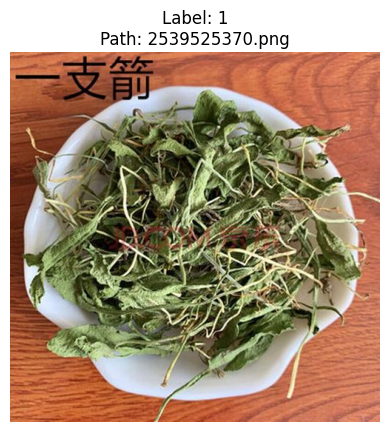

重新确认并加载训练数据信息...
成功加载 167017 条训练数据信息。
------------------------------
开始划分数据集...
数据集划分完成。
训练集样本数量: 141964
验证集样本数量: 25053
开始数据清洗过程...
开始按类别清洗数据集...


按类别清洗:   0%|          | 0/879 [00:00<?, ?it/s]

使用设备: cuda


按类别清洗:   0%|          | 1/879 [00:02<31:49,  2.18s/it]

成功提取 127 个图像的特征，特征维度: (127, 2048)
使用设备: cuda


按类别清洗:   0%|          | 2/879 [00:03<26:32,  1.82s/it]

成功提取 108 个图像的特征，特征维度: (108, 2048)
使用设备: cuda


按类别清洗:   0%|          | 3/879 [00:06<31:58,  2.19s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:   0%|          | 4/879 [00:08<32:28,  2.23s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:   1%|          | 5/879 [00:11<33:47,  2.32s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:   1%|          | 6/879 [00:13<34:34,  2.38s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:   1%|          | 7/879 [00:15<30:53,  2.13s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:   1%|          | 8/879 [00:16<26:26,  1.82s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:   1%|          | 9/879 [00:17<23:07,  1.59s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:   1%|          | 10/879 [00:18<20:30,  1.42s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:   1%|▏         | 11/879 [00:19<17:29,  1.21s/it]

成功提取 106 个图像的特征，特征维度: (106, 2048)
使用设备: cuda


按类别清洗:   1%|▏         | 12/879 [00:20<17:09,  1.19s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:   1%|▏         | 13/879 [00:21<17:14,  1.19s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:   2%|▏         | 14/879 [00:22<16:04,  1.11s/it]

成功提取 140 个图像的特征，特征维度: (140, 2048)
使用设备: cuda


按类别清洗:   2%|▏         | 15/879 [00:23<15:46,  1.10s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:   2%|▏         | 16/879 [00:24<15:59,  1.11s/it]

成功提取 174 个图像的特征，特征维度: (174, 2048)
使用设备: cuda


按类别清洗:   2%|▏         | 17/879 [00:25<16:08,  1.12s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:   2%|▏         | 18/879 [00:27<16:14,  1.13s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:   2%|▏         | 19/879 [00:28<16:18,  1.14s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:   2%|▏         | 20/879 [00:29<16:17,  1.14s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:   2%|▏         | 21/879 [00:30<16:22,  1.14s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:   3%|▎         | 22/879 [00:31<16:24,  1.15s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:   3%|▎         | 23/879 [00:32<16:41,  1.17s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:   3%|▎         | 24/879 [00:34<16:45,  1.18s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:   3%|▎         | 25/879 [00:35<17:00,  1.19s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:   3%|▎         | 26/879 [00:36<16:28,  1.16s/it]

成功提取 155 个图像的特征，特征维度: (155, 2048)
使用设备: cuda


按类别清洗:   3%|▎         | 27/879 [00:37<16:44,  1.18s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:   3%|▎         | 28/879 [00:38<16:59,  1.20s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:   3%|▎         | 29/879 [00:40<16:58,  1.20s/it]

成功提取 159 个图像的特征，特征维度: (159, 2048)
使用设备: cuda


按类别清洗:   3%|▎         | 30/879 [00:41<17:11,  1.22s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:   4%|▎         | 31/879 [00:42<17:15,  1.22s/it]

成功提取 174 个图像的特征，特征维度: (174, 2048)
使用设备: cuda


按类别清洗:   4%|▎         | 32/879 [00:43<16:21,  1.16s/it]

成功提取 156 个图像的特征，特征维度: (156, 2048)
使用设备: cuda


按类别清洗:   4%|▍         | 33/879 [00:44<16:45,  1.19s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:   4%|▍         | 34/879 [00:46<17:26,  1.24s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:   4%|▍         | 35/879 [00:47<17:54,  1.27s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:   4%|▍         | 36/879 [00:48<16:56,  1.21s/it]

成功提取 142 个图像的特征，特征维度: (142, 2048)
使用设备: cuda


按类别清洗:   4%|▍         | 37/879 [00:49<17:03,  1.22s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:   4%|▍         | 38/879 [00:51<17:26,  1.24s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:   4%|▍         | 39/879 [00:52<17:49,  1.27s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:   5%|▍         | 40/879 [00:53<16:39,  1.19s/it]

成功提取 124 个图像的特征，特征维度: (124, 2048)
使用设备: cuda


按类别清洗:   5%|▍         | 41/879 [00:54<16:50,  1.21s/it]

成功提取 173 个图像的特征，特征维度: (173, 2048)
使用设备: cuda


按类别清洗:   5%|▍         | 42/879 [00:55<17:09,  1.23s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:   5%|▍         | 43/879 [00:57<16:52,  1.21s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:   5%|▌         | 44/879 [00:58<15:41,  1.13s/it]

成功提取 133 个图像的特征，特征维度: (133, 2048)
使用设备: cuda


按类别清洗:   5%|▌         | 45/879 [00:59<15:43,  1.13s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:   5%|▌         | 46/879 [01:00<15:58,  1.15s/it]

成功提取 174 个图像的特征，特征维度: (174, 2048)
使用设备: cuda


按类别清洗:   5%|▌         | 47/879 [01:01<15:38,  1.13s/it]

成功提取 165 个图像的特征，特征维度: (165, 2048)
使用设备: cuda


按类别清洗:   5%|▌         | 48/879 [01:02<16:10,  1.17s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:   6%|▌         | 49/879 [01:03<15:10,  1.10s/it]

成功提取 142 个图像的特征，特征维度: (142, 2048)
使用设备: cuda


按类别清洗:   6%|▌         | 50/879 [01:04<15:25,  1.12s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:   6%|▌         | 51/879 [01:05<15:28,  1.12s/it]

成功提取 161 个图像的特征，特征维度: (161, 2048)
使用设备: cuda


按类别清洗:   6%|▌         | 52/879 [01:07<15:45,  1.14s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:   6%|▌         | 53/879 [01:08<16:01,  1.16s/it]

成功提取 173 个图像的特征，特征维度: (173, 2048)
使用设备: cuda


按类别清洗:   6%|▌         | 54/879 [01:09<16:06,  1.17s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:   6%|▋         | 55/879 [01:10<16:25,  1.20s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:   6%|▋         | 56/879 [01:11<15:23,  1.12s/it]

成功提取 140 个图像的特征，特征维度: (140, 2048)
使用设备: cuda


按类别清洗:   6%|▋         | 57/879 [01:12<15:31,  1.13s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:   7%|▋         | 58/879 [01:14<15:45,  1.15s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:   7%|▋         | 59/879 [01:15<15:43,  1.15s/it]

成功提取 171 个图像的特征，特征维度: (171, 2048)
使用设备: cuda


按类别清洗:   7%|▋         | 60/879 [01:16<14:57,  1.10s/it]

成功提取 141 个图像的特征，特征维度: (141, 2048)
使用设备: cuda


按类别清洗:   7%|▋         | 61/879 [01:17<15:18,  1.12s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:   7%|▋         | 62/879 [01:18<15:43,  1.15s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:   7%|▋         | 63/879 [01:19<16:08,  1.19s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:   7%|▋         | 64/879 [01:21<16:29,  1.21s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:   7%|▋         | 65/879 [01:22<16:15,  1.20s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:   8%|▊         | 66/879 [01:23<16:06,  1.19s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:   8%|▊         | 67/879 [01:24<16:12,  1.20s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:   8%|▊         | 68/879 [01:25<15:59,  1.18s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:   8%|▊         | 69/879 [01:27<15:46,  1.17s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:   8%|▊         | 70/879 [01:28<15:30,  1.15s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:   8%|▊         | 71/879 [01:29<15:25,  1.15s/it]

成功提取 159 个图像的特征，特征维度: (159, 2048)
使用设备: cuda


按类别清洗:   8%|▊         | 72/879 [01:30<15:29,  1.15s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:   8%|▊         | 73/879 [01:31<15:25,  1.15s/it]

成功提取 174 个图像的特征，特征维度: (174, 2048)
使用设备: cuda


按类别清洗:   8%|▊         | 74/879 [01:32<15:28,  1.15s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:   9%|▊         | 75/879 [01:33<15:50,  1.18s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:   9%|▊         | 76/879 [01:35<15:45,  1.18s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:   9%|▉         | 77/879 [01:36<15:54,  1.19s/it]

成功提取 174 个图像的特征，特征维度: (174, 2048)
使用设备: cuda


按类别清洗:   9%|▉         | 78/879 [01:37<15:51,  1.19s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:   9%|▉         | 79/879 [01:38<16:17,  1.22s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:   9%|▉         | 80/879 [01:39<15:50,  1.19s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:   9%|▉         | 81/879 [01:41<15:47,  1.19s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:   9%|▉         | 82/879 [01:42<16:09,  1.22s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:   9%|▉         | 83/879 [01:43<16:02,  1.21s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  10%|▉         | 84/879 [01:44<15:51,  1.20s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  10%|▉         | 85/879 [01:45<15:36,  1.18s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:  10%|▉         | 86/879 [01:47<15:32,  1.18s/it]

成功提取 174 个图像的特征，特征维度: (174, 2048)
使用设备: cuda


按类别清洗:  10%|▉         | 87/879 [01:48<15:36,  1.18s/it]

成功提取 174 个图像的特征，特征维度: (174, 2048)
使用设备: cuda


按类别清洗:  10%|█         | 88/879 [01:49<15:51,  1.20s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  10%|█         | 89/879 [01:50<15:20,  1.17s/it]

成功提取 153 个图像的特征，特征维度: (153, 2048)
使用设备: cuda


按类别清洗:  10%|█         | 90/879 [01:51<14:37,  1.11s/it]

成功提取 156 个图像的特征，特征维度: (156, 2048)
使用设备: cuda


按类别清洗:  10%|█         | 91/879 [01:52<15:05,  1.15s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  10%|█         | 92/879 [01:53<14:55,  1.14s/it]

成功提取 171 个图像的特征，特征维度: (171, 2048)
使用设备: cuda


按类别清洗:  11%|█         | 93/879 [01:55<15:22,  1.17s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  11%|█         | 94/879 [01:56<15:54,  1.22s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  11%|█         | 95/879 [01:57<15:46,  1.21s/it]

成功提取 161 个图像的特征，特征维度: (161, 2048)
使用设备: cuda


按类别清洗:  11%|█         | 96/879 [01:59<16:09,  1.24s/it]

成功提取 179 个图像的特征，特征维度: (179, 2048)
使用设备: cuda


按类别清洗:  11%|█         | 97/879 [02:00<15:33,  1.19s/it]

成功提取 143 个图像的特征，特征维度: (143, 2048)
使用设备: cuda


按类别清洗:  11%|█         | 98/879 [02:01<15:53,  1.22s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  11%|█▏        | 99/879 [02:02<15:04,  1.16s/it]

成功提取 155 个图像的特征，特征维度: (155, 2048)
使用设备: cuda


按类别清洗:  11%|█▏        | 100/879 [02:03<15:00,  1.16s/it]

成功提取 161 个图像的特征，特征维度: (161, 2048)
使用设备: cuda


按类别清洗:  11%|█▏        | 101/879 [02:04<13:54,  1.07s/it]

成功提取 122 个图像的特征，特征维度: (122, 2048)
使用设备: cuda


按类别清洗:  12%|█▏        | 102/879 [02:05<14:53,  1.15s/it]

成功提取 156 个图像的特征，特征维度: (156, 2048)
使用设备: cuda


按类别清洗:  12%|█▏        | 103/879 [02:07<15:30,  1.20s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  12%|█▏        | 104/879 [02:08<15:56,  1.23s/it]

成功提取 173 个图像的特征，特征维度: (173, 2048)
使用设备: cuda


按类别清洗:  12%|█▏        | 105/879 [02:09<16:01,  1.24s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  12%|█▏        | 106/879 [02:10<15:40,  1.22s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:  12%|█▏        | 107/879 [02:12<15:41,  1.22s/it]

成功提取 160 个图像的特征，特征维度: (160, 2048)
使用设备: cuda


按类别清洗:  12%|█▏        | 108/879 [02:13<15:44,  1.23s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  12%|█▏        | 109/879 [02:14<14:31,  1.13s/it]

成功提取 121 个图像的特征，特征维度: (121, 2048)
使用设备: cuda


按类别清洗:  13%|█▎        | 110/879 [02:15<13:56,  1.09s/it]

成功提取 139 个图像的特征，特征维度: (139, 2048)
使用设备: cuda


按类别清洗:  13%|█▎        | 111/879 [02:16<14:46,  1.15s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:  13%|█▎        | 112/879 [02:17<15:30,  1.21s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  13%|█▎        | 113/879 [02:18<15:06,  1.18s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:  13%|█▎        | 114/879 [02:20<15:48,  1.24s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  13%|█▎        | 115/879 [02:21<16:18,  1.28s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  13%|█▎        | 116/879 [02:22<15:59,  1.26s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  13%|█▎        | 117/879 [02:24<16:08,  1.27s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  13%|█▎        | 118/879 [02:25<15:57,  1.26s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:  14%|█▎        | 119/879 [02:26<15:16,  1.21s/it]

成功提取 140 个图像的特征，特征维度: (140, 2048)
使用设备: cuda


按类别清洗:  14%|█▎        | 120/879 [02:27<15:41,  1.24s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  14%|█▍        | 121/879 [02:29<15:46,  1.25s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  14%|█▍        | 122/879 [02:30<15:23,  1.22s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:  14%|█▍        | 123/879 [02:31<15:39,  1.24s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  14%|█▍        | 124/879 [02:32<15:26,  1.23s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  14%|█▍        | 125/879 [02:33<13:13,  1.05s/it]

成功提取 74 个图像的特征，特征维度: (74, 2048)
使用设备: cuda


按类别清洗:  14%|█▍        | 126/879 [02:34<13:38,  1.09s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  14%|█▍        | 127/879 [02:35<13:54,  1.11s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:  15%|█▍        | 128/879 [02:37<14:27,  1.16s/it]

成功提取 156 个图像的特征，特征维度: (156, 2048)
使用设备: cuda


按类别清洗:  15%|█▍        | 129/879 [02:38<14:59,  1.20s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:  15%|█▍        | 130/879 [02:39<14:47,  1.19s/it]

成功提取 174 个图像的特征，特征维度: (174, 2048)
使用设备: cuda


按类别清洗:  15%|█▍        | 131/879 [02:40<14:24,  1.16s/it]

成功提取 159 个图像的特征，特征维度: (159, 2048)
使用设备: cuda


按类别清洗:  15%|█▌        | 132/879 [02:41<15:08,  1.22s/it]

成功提取 179 个图像的特征，特征维度: (179, 2048)
使用设备: cuda


按类别清洗:  15%|█▌        | 133/879 [02:43<14:44,  1.19s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:  15%|█▌        | 134/879 [02:44<15:04,  1.21s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  15%|█▌        | 135/879 [02:45<14:29,  1.17s/it]

成功提取 143 个图像的特征，特征维度: (143, 2048)
使用设备: cuda


按类别清洗:  15%|█▌        | 136/879 [02:46<14:41,  1.19s/it]

成功提取 160 个图像的特征，特征维度: (160, 2048)
使用设备: cuda


按类别清洗:  16%|█▌        | 137/879 [02:47<14:26,  1.17s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:  16%|█▌        | 138/879 [02:48<14:40,  1.19s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  16%|█▌        | 139/879 [02:50<14:19,  1.16s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:  16%|█▌        | 140/879 [02:51<14:25,  1.17s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  16%|█▌        | 141/879 [02:52<14:30,  1.18s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  16%|█▌        | 142/879 [02:53<14:21,  1.17s/it]

成功提取 159 个图像的特征，特征维度: (159, 2048)
使用设备: cuda


按类别清洗:  16%|█▋        | 143/879 [02:54<13:32,  1.10s/it]

成功提取 141 个图像的特征，特征维度: (141, 2048)
使用设备: cuda


按类别清洗:  16%|█▋        | 144/879 [02:55<14:09,  1.16s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  16%|█▋        | 145/879 [02:57<14:26,  1.18s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  17%|█▋        | 146/879 [02:58<14:18,  1.17s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:  17%|█▋        | 147/879 [02:59<14:40,  1.20s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  17%|█▋        | 148/879 [03:00<14:37,  1.20s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:  17%|█▋        | 149/879 [03:01<14:29,  1.19s/it]

成功提取 162 个图像的特征，特征维度: (162, 2048)
使用设备: cuda


按类别清洗:  17%|█▋        | 150/879 [03:02<13:52,  1.14s/it]

成功提取 142 个图像的特征，特征维度: (142, 2048)
使用设备: cuda


按类别清洗:  17%|█▋        | 151/879 [03:04<14:15,  1.18s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  17%|█▋        | 152/879 [03:05<14:16,  1.18s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:  17%|█▋        | 153/879 [03:06<13:50,  1.14s/it]

成功提取 140 个图像的特征，特征维度: (140, 2048)
使用设备: cuda


按类别清洗:  18%|█▊        | 154/879 [03:07<13:43,  1.14s/it]

成功提取 156 个图像的特征，特征维度: (156, 2048)
使用设备: cuda


按类别清洗:  18%|█▊        | 155/879 [03:08<13:33,  1.12s/it]

成功提取 171 个图像的特征，特征维度: (171, 2048)
使用设备: cuda


按类别清洗:  18%|█▊        | 156/879 [03:09<13:55,  1.16s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  18%|█▊        | 157/879 [03:11<14:10,  1.18s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  18%|█▊        | 158/879 [03:12<14:01,  1.17s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:  18%|█▊        | 159/879 [03:13<13:58,  1.16s/it]

成功提取 159 个图像的特征，特征维度: (159, 2048)
使用设备: cuda


按类别清洗:  18%|█▊        | 160/879 [03:14<13:42,  1.14s/it]

成功提取 150 个图像的特征，特征维度: (150, 2048)
使用设备: cuda


按类别清洗:  18%|█▊        | 161/879 [03:15<13:34,  1.13s/it]

成功提取 156 个图像的特征，特征维度: (156, 2048)
使用设备: cuda


按类别清洗:  18%|█▊        | 162/879 [03:16<13:54,  1.16s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  19%|█▊        | 163/879 [03:18<14:15,  1.19s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  19%|█▊        | 164/879 [03:19<13:26,  1.13s/it]

成功提取 141 个图像的特征，特征维度: (141, 2048)
使用设备: cuda


按类别清洗:  19%|█▉        | 165/879 [03:20<13:42,  1.15s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  19%|█▉        | 166/879 [03:21<13:46,  1.16s/it]

成功提取 155 个图像的特征，特征维度: (155, 2048)
使用设备: cuda


按类别清洗:  19%|█▉        | 167/879 [03:22<14:36,  1.23s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  19%|█▉        | 168/879 [03:23<13:44,  1.16s/it]

成功提取 140 个图像的特征，特征维度: (140, 2048)
使用设备: cuda


按类别清洗:  19%|█▉        | 169/879 [03:25<13:59,  1.18s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  19%|█▉        | 170/879 [03:26<13:56,  1.18s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  19%|█▉        | 171/879 [03:27<13:50,  1.17s/it]

成功提取 172 个图像的特征，特征维度: (172, 2048)
使用设备: cuda


按类别清洗:  20%|█▉        | 172/879 [03:28<12:52,  1.09s/it]

成功提取 122 个图像的特征，特征维度: (122, 2048)
使用设备: cuda


按类别清洗:  20%|█▉        | 173/879 [03:29<13:11,  1.12s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  20%|█▉        | 174/879 [03:30<13:43,  1.17s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  20%|█▉        | 175/879 [03:32<14:10,  1.21s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  20%|██        | 176/879 [03:33<13:40,  1.17s/it]

成功提取 140 个图像的特征，特征维度: (140, 2048)
使用设备: cuda


按类别清洗:  20%|██        | 177/879 [03:34<13:45,  1.18s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  20%|██        | 178/879 [03:35<13:33,  1.16s/it]

成功提取 160 个图像的特征，特征维度: (160, 2048)
使用设备: cuda


按类别清洗:  20%|██        | 179/879 [03:36<11:33,  1.01it/s]

成功提取 61 个图像的特征，特征维度: (61, 2048)
使用设备: cuda


按类别清洗:  20%|██        | 180/879 [03:37<12:04,  1.04s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  21%|██        | 181/879 [03:38<11:50,  1.02s/it]

成功提取 140 个图像的特征，特征维度: (140, 2048)
使用设备: cuda


按类别清洗:  21%|██        | 182/879 [03:39<12:26,  1.07s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  21%|██        | 183/879 [03:40<12:45,  1.10s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:  21%|██        | 184/879 [03:41<12:54,  1.11s/it]

成功提取 170 个图像的特征，特征维度: (170, 2048)
使用设备: cuda


按类别清洗:  21%|██        | 185/879 [03:42<13:03,  1.13s/it]

成功提取 173 个图像的特征，特征维度: (173, 2048)
使用设备: cuda


按类别清洗:  21%|██        | 186/879 [03:43<13:12,  1.14s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:  21%|██▏       | 187/879 [03:45<12:51,  1.12s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:  21%|██▏       | 188/879 [03:46<12:36,  1.09s/it]

成功提取 159 个图像的特征，特征维度: (159, 2048)
使用设备: cuda


按类别清洗:  22%|██▏       | 189/879 [03:47<12:51,  1.12s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:  22%|██▏       | 190/879 [03:48<13:10,  1.15s/it]

成功提取 161 个图像的特征，特征维度: (161, 2048)
使用设备: cuda


按类别清洗:  22%|██▏       | 191/879 [03:49<13:07,  1.14s/it]

成功提取 167 个图像的特征，特征维度: (167, 2048)
使用设备: cuda


按类别清洗:  22%|██▏       | 192/879 [03:50<13:24,  1.17s/it]

成功提取 179 个图像的特征，特征维度: (179, 2048)
使用设备: cuda


按类别清洗:  22%|██▏       | 193/879 [03:51<12:27,  1.09s/it]

成功提取 142 个图像的特征，特征维度: (142, 2048)
使用设备: cuda


按类别清洗:  22%|██▏       | 194/879 [03:52<12:30,  1.10s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  22%|██▏       | 195/879 [03:54<12:44,  1.12s/it]

成功提取 173 个图像的特征，特征维度: (173, 2048)
使用设备: cuda


按类别清洗:  22%|██▏       | 196/879 [03:55<12:38,  1.11s/it]

成功提取 161 个图像的特征，特征维度: (161, 2048)
使用设备: cuda


按类别清洗:  22%|██▏       | 197/879 [03:56<12:53,  1.13s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  23%|██▎       | 198/879 [03:57<13:07,  1.16s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  23%|██▎       | 199/879 [03:58<13:23,  1.18s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  23%|██▎       | 200/879 [03:59<13:01,  1.15s/it]

成功提取 153 个图像的特征，特征维度: (153, 2048)
使用设备: cuda


按类别清洗:  23%|██▎       | 201/879 [04:01<13:10,  1.17s/it]

成功提取 159 个图像的特征，特征维度: (159, 2048)
使用设备: cuda


按类别清洗:  23%|██▎       | 202/879 [04:02<13:12,  1.17s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  23%|██▎       | 203/879 [04:03<13:11,  1.17s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:  23%|██▎       | 204/879 [04:04<13:15,  1.18s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  23%|██▎       | 205/879 [04:05<13:27,  1.20s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  23%|██▎       | 206/879 [04:07<13:32,  1.21s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  24%|██▎       | 207/879 [04:08<13:28,  1.20s/it]

成功提取 157 个图像的特征，特征维度: (157, 2048)
使用设备: cuda


按类别清洗:  24%|██▎       | 208/879 [04:09<12:50,  1.15s/it]

成功提取 157 个图像的特征，特征维度: (157, 2048)
使用设备: cuda


按类别清洗:  24%|██▍       | 209/879 [04:10<12:13,  1.09s/it]

成功提取 146 个图像的特征，特征维度: (146, 2048)
使用设备: cuda


按类别清洗:  24%|██▍       | 210/879 [04:11<12:19,  1.11s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  24%|██▍       | 211/879 [04:12<12:27,  1.12s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  24%|██▍       | 212/879 [04:13<12:34,  1.13s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:  24%|██▍       | 213/879 [04:14<13:01,  1.17s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:  24%|██▍       | 214/879 [04:16<12:54,  1.17s/it]

成功提取 156 个图像的特征，特征维度: (156, 2048)
使用设备: cuda


按类别清洗:  24%|██▍       | 215/879 [04:17<12:57,  1.17s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  25%|██▍       | 216/879 [04:18<13:01,  1.18s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:  25%|██▍       | 217/879 [04:19<13:14,  1.20s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  25%|██▍       | 218/879 [04:21<13:52,  1.26s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  25%|██▍       | 219/879 [04:22<13:47,  1.25s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  25%|██▌       | 220/879 [04:23<13:29,  1.23s/it]

成功提取 157 个图像的特征，特征维度: (157, 2048)
使用设备: cuda


按类别清洗:  25%|██▌       | 221/879 [04:24<12:43,  1.16s/it]

成功提取 139 个图像的特征，特征维度: (139, 2048)
使用设备: cuda


按类别清洗:  25%|██▌       | 222/879 [04:25<12:30,  1.14s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:  25%|██▌       | 223/879 [04:26<12:26,  1.14s/it]

成功提取 174 个图像的特征，特征维度: (174, 2048)
使用设备: cuda


按类别清洗:  25%|██▌       | 224/879 [04:28<12:46,  1.17s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:  26%|██▌       | 225/879 [04:29<12:31,  1.15s/it]

成功提取 157 个图像的特征，特征维度: (157, 2048)
使用设备: cuda


按类别清洗:  26%|██▌       | 226/879 [04:30<13:48,  1.27s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  26%|██▌       | 227/879 [04:31<13:21,  1.23s/it]

成功提取 155 个图像的特征，特征维度: (155, 2048)
使用设备: cuda


按类别清洗:  26%|██▌       | 228/879 [04:32<12:56,  1.19s/it]

成功提取 160 个图像的特征，特征维度: (160, 2048)
使用设备: cuda


按类别清洗:  26%|██▌       | 229/879 [04:34<12:40,  1.17s/it]

成功提取 151 个图像的特征，特征维度: (151, 2048)
使用设备: cuda


按类别清洗:  26%|██▌       | 230/879 [04:35<12:48,  1.18s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  26%|██▋       | 231/879 [04:36<13:06,  1.21s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  26%|██▋       | 232/879 [04:37<12:55,  1.20s/it]

成功提取 173 个图像的特征，特征维度: (173, 2048)
使用设备: cuda


按类别清洗:  27%|██▋       | 233/879 [04:38<12:46,  1.19s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  27%|██▋       | 234/879 [04:39<12:28,  1.16s/it]

成功提取 159 个图像的特征，特征维度: (159, 2048)
使用设备: cuda


按类别清洗:  27%|██▋       | 235/879 [04:41<12:10,  1.13s/it]

成功提取 143 个图像的特征，特征维度: (143, 2048)
使用设备: cuda


按类别清洗:  27%|██▋       | 236/879 [04:42<12:09,  1.13s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  27%|██▋       | 237/879 [04:43<12:12,  1.14s/it]

成功提取 174 个图像的特征，特征维度: (174, 2048)
使用设备: cuda


按类别清洗:  27%|██▋       | 238/879 [04:44<12:19,  1.15s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:  27%|██▋       | 239/879 [04:45<12:25,  1.17s/it]

成功提取 174 个图像的特征，特征维度: (174, 2048)
使用设备: cuda


按类别清洗:  27%|██▋       | 240/879 [04:46<12:46,  1.20s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  27%|██▋       | 241/879 [04:48<12:42,  1.19s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  28%|██▊       | 242/879 [04:49<12:55,  1.22s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  28%|██▊       | 243/879 [04:50<12:52,  1.21s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  28%|██▊       | 244/879 [04:51<12:28,  1.18s/it]

成功提取 157 个图像的特征，特征维度: (157, 2048)
使用设备: cuda


按类别清洗:  28%|██▊       | 245/879 [04:52<12:31,  1.19s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:  28%|██▊       | 246/879 [04:54<12:50,  1.22s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  28%|██▊       | 247/879 [04:55<12:45,  1.21s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  28%|██▊       | 248/879 [04:56<13:02,  1.24s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  28%|██▊       | 249/879 [04:57<12:33,  1.20s/it]

成功提取 149 个图像的特征，特征维度: (149, 2048)
使用设备: cuda


按类别清洗:  28%|██▊       | 250/879 [04:59<12:37,  1.20s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  29%|██▊       | 251/879 [05:00<12:47,  1.22s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  29%|██▊       | 252/879 [05:01<13:05,  1.25s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  29%|██▉       | 253/879 [05:02<12:37,  1.21s/it]

成功提取 159 个图像的特征，特征维度: (159, 2048)
使用设备: cuda


按类别清洗:  29%|██▉       | 254/879 [05:03<11:59,  1.15s/it]

成功提取 157 个图像的特征，特征维度: (157, 2048)
使用设备: cuda


按类别清洗:  29%|██▉       | 255/879 [05:04<11:58,  1.15s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  29%|██▉       | 256/879 [05:06<12:14,  1.18s/it]

成功提取 157 个图像的特征，特征维度: (157, 2048)
使用设备: cuda


按类别清洗:  29%|██▉       | 257/879 [05:07<12:11,  1.18s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  29%|██▉       | 258/879 [05:08<12:03,  1.16s/it]

成功提取 159 个图像的特征，特征维度: (159, 2048)
使用设备: cuda


按类别清洗:  29%|██▉       | 259/879 [05:09<12:04,  1.17s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:  30%|██▉       | 260/879 [05:10<12:07,  1.18s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  30%|██▉       | 261/879 [05:11<11:59,  1.16s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  30%|██▉       | 262/879 [05:13<12:05,  1.18s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  30%|██▉       | 263/879 [05:14<11:56,  1.16s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  30%|███       | 264/879 [05:15<12:04,  1.18s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  30%|███       | 265/879 [05:16<11:45,  1.15s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  30%|███       | 266/879 [05:17<11:24,  1.12s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:  30%|███       | 267/879 [05:18<11:40,  1.14s/it]

成功提取 173 个图像的特征，特征维度: (173, 2048)
使用设备: cuda


按类别清洗:  30%|███       | 268/879 [05:20<11:53,  1.17s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:  31%|███       | 269/879 [05:21<11:44,  1.16s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  31%|███       | 270/879 [05:22<11:51,  1.17s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  31%|███       | 271/879 [05:23<11:39,  1.15s/it]

成功提取 159 个图像的特征，特征维度: (159, 2048)
使用设备: cuda


按类别清洗:  31%|███       | 272/879 [05:24<11:13,  1.11s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:  31%|███       | 273/879 [05:25<10:44,  1.06s/it]

成功提取 140 个图像的特征，特征维度: (140, 2048)
使用设备: cuda


按类别清洗:  31%|███       | 274/879 [05:26<10:49,  1.07s/it]

成功提取 143 个图像的特征，特征维度: (143, 2048)
使用设备: cuda


按类别清洗:  31%|███▏      | 275/879 [05:27<11:08,  1.11s/it]

成功提取 174 个图像的特征，特征维度: (174, 2048)
使用设备: cuda


按类别清洗:  31%|███▏      | 276/879 [05:29<11:39,  1.16s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  32%|███▏      | 277/879 [05:30<11:39,  1.16s/it]

成功提取 174 个图像的特征，特征维度: (174, 2048)
使用设备: cuda


按类别清洗:  32%|███▏      | 278/879 [05:31<12:05,  1.21s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  32%|███▏      | 279/879 [05:32<12:30,  1.25s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  32%|███▏      | 280/879 [05:34<12:17,  1.23s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  32%|███▏      | 281/879 [05:35<12:14,  1.23s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  32%|███▏      | 282/879 [05:36<12:08,  1.22s/it]

成功提取 155 个图像的特征，特征维度: (155, 2048)
使用设备: cuda


按类别清洗:  32%|███▏      | 283/879 [05:37<11:58,  1.21s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:  32%|███▏      | 284/879 [05:38<12:22,  1.25s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  32%|███▏      | 285/879 [05:40<11:57,  1.21s/it]

成功提取 156 个图像的特征，特征维度: (156, 2048)
使用设备: cuda


按类别清洗:  33%|███▎      | 286/879 [05:41<11:29,  1.16s/it]

成功提取 139 个图像的特征，特征维度: (139, 2048)
使用设备: cuda


按类别清洗:  33%|███▎      | 287/879 [05:42<10:53,  1.10s/it]

成功提取 140 个图像的特征，特征维度: (140, 2048)
使用设备: cuda


按类别清洗:  33%|███▎      | 288/879 [05:43<10:16,  1.04s/it]

成功提取 125 个图像的特征，特征维度: (125, 2048)
使用设备: cuda


按类别清洗:  33%|███▎      | 289/879 [05:44<10:34,  1.08s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  33%|███▎      | 290/879 [05:45<10:56,  1.11s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  33%|███▎      | 291/879 [05:46<11:25,  1.17s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  33%|███▎      | 292/879 [05:47<11:22,  1.16s/it]

成功提取 171 个图像的特征，特征维度: (171, 2048)
使用设备: cuda


按类别清洗:  33%|███▎      | 293/879 [05:48<11:18,  1.16s/it]

成功提取 154 个图像的特征，特征维度: (154, 2048)
使用设备: cuda


按类别清洗:  33%|███▎      | 294/879 [05:49<10:45,  1.10s/it]

成功提取 137 个图像的特征，特征维度: (137, 2048)
使用设备: cuda


按类别清洗:  34%|███▎      | 295/879 [05:51<10:44,  1.10s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  34%|███▎      | 296/879 [05:52<10:45,  1.11s/it]

成功提取 161 个图像的特征，特征维度: (161, 2048)
使用设备: cuda


按类别清洗:  34%|███▍      | 297/879 [05:53<11:04,  1.14s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  34%|███▍      | 298/879 [05:54<11:16,  1.16s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  34%|███▍      | 299/879 [05:55<11:05,  1.15s/it]

成功提取 174 个图像的特征，特征维度: (174, 2048)
使用设备: cuda


按类别清洗:  34%|███▍      | 300/879 [05:56<10:42,  1.11s/it]

成功提取 141 个图像的特征，特征维度: (141, 2048)
使用设备: cuda


按类别清洗:  34%|███▍      | 301/879 [05:57<10:53,  1.13s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  34%|███▍      | 302/879 [05:59<11:04,  1.15s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  34%|███▍      | 303/879 [06:00<11:22,  1.19s/it]

成功提取 174 个图像的特征，特征维度: (174, 2048)
使用设备: cuda


按类别清洗:  35%|███▍      | 304/879 [06:01<11:30,  1.20s/it]

成功提取 174 个图像的特征，特征维度: (174, 2048)
使用设备: cuda


按类别清洗:  35%|███▍      | 305/879 [06:02<11:33,  1.21s/it]

成功提取 156 个图像的特征，特征维度: (156, 2048)
使用设备: cuda


按类别清洗:  35%|███▍      | 306/879 [06:03<11:20,  1.19s/it]

成功提取 146 个图像的特征，特征维度: (146, 2048)
使用设备: cuda


按类别清洗:  35%|███▍      | 307/879 [06:05<10:50,  1.14s/it]

成功提取 131 个图像的特征，特征维度: (131, 2048)
使用设备: cuda


按类别清洗:  35%|███▌      | 308/879 [06:06<11:21,  1.19s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  35%|███▌      | 309/879 [06:07<11:08,  1.17s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:  35%|███▌      | 310/879 [06:08<10:50,  1.14s/it]

成功提取 140 个图像的特征，特征维度: (140, 2048)
使用设备: cuda


按类别清洗:  35%|███▌      | 311/879 [06:09<11:05,  1.17s/it]

成功提取 159 个图像的特征，特征维度: (159, 2048)
使用设备: cuda


按类别清洗:  35%|███▌      | 312/879 [06:10<10:17,  1.09s/it]

成功提取 115 个图像的特征，特征维度: (115, 2048)
使用设备: cuda


按类别清洗:  36%|███▌      | 313/879 [06:11<10:54,  1.16s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  36%|███▌      | 314/879 [06:13<11:08,  1.18s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  36%|███▌      | 315/879 [06:14<11:21,  1.21s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  36%|███▌      | 316/879 [06:15<11:39,  1.24s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  36%|███▌      | 317/879 [06:17<11:46,  1.26s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  36%|███▌      | 318/879 [06:18<11:39,  1.25s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  36%|███▋      | 319/879 [06:19<11:24,  1.22s/it]

成功提取 173 个图像的特征，特征维度: (173, 2048)
使用设备: cuda


按类别清洗:  36%|███▋      | 320/879 [06:20<11:10,  1.20s/it]

成功提取 174 个图像的特征，特征维度: (174, 2048)
使用设备: cuda


按类别清洗:  37%|███▋      | 321/879 [06:21<11:13,  1.21s/it]

成功提取 174 个图像的特征，特征维度: (174, 2048)
使用设备: cuda


按类别清洗:  37%|███▋      | 322/879 [06:23<11:09,  1.20s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  37%|███▋      | 323/879 [06:24<11:09,  1.20s/it]

成功提取 160 个图像的特征，特征维度: (160, 2048)
使用设备: cuda


按类别清洗:  37%|███▋      | 324/879 [06:25<10:20,  1.12s/it]

成功提取 124 个图像的特征，特征维度: (124, 2048)
使用设备: cuda


按类别清洗:  37%|███▋      | 325/879 [06:26<10:11,  1.10s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:  37%|███▋      | 326/879 [06:27<10:32,  1.14s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  37%|███▋      | 327/879 [06:28<10:54,  1.19s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  37%|███▋      | 328/879 [06:30<11:16,  1.23s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  37%|███▋      | 329/879 [06:31<11:02,  1.20s/it]

成功提取 159 个图像的特征，特征维度: (159, 2048)
使用设备: cuda


按类别清洗:  38%|███▊      | 330/879 [06:32<10:44,  1.17s/it]

成功提取 159 个图像的特征，特征维度: (159, 2048)
使用设备: cuda


按类别清洗:  38%|███▊      | 331/879 [06:33<10:35,  1.16s/it]

成功提取 157 个图像的特征，特征维度: (157, 2048)
使用设备: cuda


按类别清洗:  38%|███▊      | 332/879 [06:34<11:03,  1.21s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  38%|███▊      | 333/879 [06:36<11:10,  1.23s/it]

成功提取 173 个图像的特征，特征维度: (173, 2048)
使用设备: cuda


按类别清洗:  38%|███▊      | 334/879 [06:37<11:23,  1.25s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  38%|███▊      | 335/879 [06:38<10:56,  1.21s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:  38%|███▊      | 336/879 [06:39<11:06,  1.23s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  38%|███▊      | 337/879 [06:40<10:56,  1.21s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  38%|███▊      | 338/879 [06:41<10:21,  1.15s/it]

成功提取 142 个图像的特征，特征维度: (142, 2048)
使用设备: cuda


按类别清洗:  39%|███▊      | 339/879 [06:43<10:35,  1.18s/it]

成功提取 170 个图像的特征，特征维度: (170, 2048)
使用设备: cuda


按类别清洗:  39%|███▊      | 340/879 [06:44<11:10,  1.24s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  39%|███▉      | 341/879 [06:45<11:09,  1.24s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  39%|███▉      | 342/879 [06:46<10:52,  1.22s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  39%|███▉      | 343/879 [06:48<10:52,  1.22s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  39%|███▉      | 344/879 [06:49<10:18,  1.16s/it]

成功提取 125 个图像的特征，特征维度: (125, 2048)
使用设备: cuda


按类别清洗:  39%|███▉      | 345/879 [06:50<10:30,  1.18s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  39%|███▉      | 346/879 [06:51<10:07,  1.14s/it]

成功提取 141 个图像的特征，特征维度: (141, 2048)
使用设备: cuda


按类别清洗:  39%|███▉      | 347/879 [06:52<10:22,  1.17s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  40%|███▉      | 348/879 [06:53<10:20,  1.17s/it]

成功提取 172 个图像的特征，特征维度: (172, 2048)
使用设备: cuda


按类别清洗:  40%|███▉      | 349/879 [06:55<10:24,  1.18s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  40%|███▉      | 350/879 [06:56<10:27,  1.19s/it]

成功提取 173 个图像的特征，特征维度: (173, 2048)
使用设备: cuda


按类别清洗:  40%|███▉      | 351/879 [06:57<10:34,  1.20s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  40%|████      | 352/879 [06:58<10:20,  1.18s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  40%|████      | 353/879 [06:59<10:22,  1.18s/it]

成功提取 160 个图像的特征，特征维度: (160, 2048)
使用设备: cuda


按类别清洗:  40%|████      | 354/879 [07:01<10:24,  1.19s/it]

成功提取 160 个图像的特征，特征维度: (160, 2048)
使用设备: cuda


按类别清洗:  40%|████      | 355/879 [07:02<10:21,  1.19s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  41%|████      | 356/879 [07:03<10:26,  1.20s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  41%|████      | 357/879 [07:04<09:50,  1.13s/it]

成功提取 124 个图像的特征，特征维度: (124, 2048)
使用设备: cuda


按类别清洗:  41%|████      | 358/879 [07:05<09:59,  1.15s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  41%|████      | 359/879 [07:06<10:00,  1.15s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  41%|████      | 360/879 [07:07<10:06,  1.17s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  41%|████      | 361/879 [07:08<09:36,  1.11s/it]

成功提取 141 个图像的特征，特征维度: (141, 2048)
使用设备: cuda


按类别清洗:  41%|████      | 362/879 [07:09<09:13,  1.07s/it]

成功提取 139 个图像的特征，特征维度: (139, 2048)
使用设备: cuda


按类别清洗:  41%|████▏     | 363/879 [07:11<09:35,  1.11s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:  41%|████▏     | 364/879 [07:12<09:46,  1.14s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  42%|████▏     | 365/879 [07:13<09:43,  1.13s/it]

成功提取 160 个图像的特征，特征维度: (160, 2048)
使用设备: cuda


按类别清洗:  42%|████▏     | 366/879 [07:14<09:18,  1.09s/it]

成功提取 139 个图像的特征，特征维度: (139, 2048)
使用设备: cuda


按类别清洗:  42%|████▏     | 367/879 [07:15<09:30,  1.11s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  42%|████▏     | 368/879 [07:16<09:22,  1.10s/it]

成功提取 143 个图像的特征，特征维度: (143, 2048)
使用设备: cuda


按类别清洗:  42%|████▏     | 369/879 [07:17<09:39,  1.14s/it]

成功提取 173 个图像的特征，特征维度: (173, 2048)
使用设备: cuda


按类别清洗:  42%|████▏     | 370/879 [07:18<09:21,  1.10s/it]

成功提取 150 个图像的特征，特征维度: (150, 2048)
使用设备: cuda


按类别清洗:  42%|████▏     | 371/879 [07:20<09:23,  1.11s/it]

成功提取 159 个图像的特征，特征维度: (159, 2048)
使用设备: cuda


按类别清洗:  42%|████▏     | 372/879 [07:21<09:38,  1.14s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  42%|████▏     | 373/879 [07:22<09:08,  1.08s/it]

成功提取 142 个图像的特征，特征维度: (142, 2048)
使用设备: cuda


按类别清洗:  43%|████▎     | 374/879 [07:23<09:22,  1.11s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  43%|████▎     | 375/879 [07:24<09:41,  1.15s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  43%|████▎     | 376/879 [07:25<08:28,  1.01s/it]

成功提取 77 个图像的特征，特征维度: (77, 2048)
使用设备: cuda


按类别清洗:  43%|████▎     | 377/879 [07:26<08:22,  1.00s/it]

成功提取 146 个图像的特征，特征维度: (146, 2048)
使用设备: cuda


按类别清洗:  43%|████▎     | 378/879 [07:27<08:22,  1.00s/it]

成功提取 140 个图像的特征，特征维度: (140, 2048)
使用设备: cuda


按类别清洗:  43%|████▎     | 379/879 [07:28<08:13,  1.01it/s]

成功提取 156 个图像的特征，特征维度: (156, 2048)
使用设备: cuda


按类别清洗:  43%|████▎     | 380/879 [07:29<08:32,  1.03s/it]

成功提取 177 个图像的特征，特征维度: (177, 2048)
使用设备: cuda


按类别清洗:  43%|████▎     | 381/879 [07:30<09:23,  1.13s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  43%|████▎     | 382/879 [07:31<09:23,  1.13s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:  44%|████▎     | 383/879 [07:32<09:05,  1.10s/it]

成功提取 155 个图像的特征，特征维度: (155, 2048)
使用设备: cuda


按类别清洗:  44%|████▎     | 384/879 [07:34<09:11,  1.11s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:  44%|████▍     | 385/879 [07:35<09:19,  1.13s/it]

成功提取 161 个图像的特征，特征维度: (161, 2048)
使用设备: cuda


按类别清洗:  44%|████▍     | 386/879 [07:36<09:29,  1.16s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  44%|████▍     | 387/879 [07:37<09:39,  1.18s/it]

成功提取 174 个图像的特征，特征维度: (174, 2048)
使用设备: cuda


按类别清洗:  44%|████▍     | 388/879 [07:38<09:54,  1.21s/it]

成功提取 176 个图像的特征，特征维度: (176, 2048)
使用设备: cuda


按类别清洗:  44%|████▍     | 389/879 [07:40<09:55,  1.22s/it]

成功提取 174 个图像的特征，特征维度: (174, 2048)
使用设备: cuda


按类别清洗:  44%|████▍     | 390/879 [07:41<10:10,  1.25s/it]

成功提取 178 个图像的特征，特征维度: (178, 2048)
使用设备: cuda


按类别清洗:  44%|████▍     | 391/879 [07:42<10:02,  1.23s/it]

成功提取 174 个图像的特征，特征维度: (174, 2048)
使用设备: cuda


按类别清洗:  45%|████▍     | 392/879 [07:43<09:45,  1.20s/it]

成功提取 143 个图像的特征，特征维度: (143, 2048)
使用设备: cuda


按类别清洗:  45%|████▍     | 393/879 [07:45<09:50,  1.22s/it]

成功提取 175 个图像的特征，特征维度: (175, 2048)
使用设备: cuda


按类别清洗:  45%|████▍     | 394/879 [07:46<09:28,  1.17s/it]

成功提取 141 个图像的特征，特征维度: (141, 2048)
使用设备: cuda


按类别清洗:  45%|████▍     | 395/879 [07:47<09:21,  1.16s/it]

成功提取 161 个图像的特征，特征维度: (161, 2048)
使用设备: cuda


按类别清洗:  45%|████▌     | 396/879 [07:48<09:11,  1.14s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:  45%|████▌     | 397/879 [07:49<09:21,  1.16s/it]

成功提取 160 个图像的特征，特征维度: (160, 2048)
使用设备: cuda


按类别清洗:  45%|████▌     | 398/879 [07:50<09:28,  1.18s/it]

成功提取 174 个图像的特征，特征维度: (174, 2048)
使用设备: cuda


按类别清洗:  45%|████▌     | 399/879 [07:51<09:17,  1.16s/it]

成功提取 155 个图像的特征，特征维度: (155, 2048)
使用设备: cuda


按类别清洗:  46%|████▌     | 400/879 [07:52<08:49,  1.10s/it]

成功提取 140 个图像的特征，特征维度: (140, 2048)
使用设备: cuda


按类别清洗:  46%|████▌     | 401/879 [07:53<08:33,  1.07s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:  46%|████▌     | 402/879 [07:55<08:42,  1.09s/it]

成功提取 158 个图像的特征，特征维度: (158, 2048)
使用设备: cuda


按类别清洗:  46%|████▌     | 403/879 [07:56<09:01,  1.14s/it]

成功提取 160 个图像的特征，特征维度: (160, 2048)
使用设备: cuda


按类别清洗:  46%|████▌     | 404/879 [07:57<09:34,  1.21s/it]

成功提取 172 个图像的特征，特征维度: (172, 2048)
使用设备: cuda


按类别清洗:  46%|████▌     | 405/879 [07:58<09:27,  1.20s/it]

成功提取 172 个图像的特征，特征维度: (172, 2048)
使用设备: cuda


按类别清洗:  46%|████▌     | 405/879 [07:59<09:20,  1.18s/it]


KeyboardInterrupt: 

In [7]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

# 定义数据集的根目录
base_dir = 'chinese-medicine-image'
train_dir = os.path.join(base_dir, 'train', 'train')
test_dir = os.path.join(base_dir, 'test', 'test')
train_labels_file = os.path.join(base_dir, 'train_labels.csv')

# --- 1. 加载训练数据信息 ---
print("开始加载训练数据信息...")
try:
    train_df = pd.read_csv(train_labels_file)
    # 确保ID列是图片文件的相对路径，方便后续拼接
    # train_labels.csv中的ID已经是 "train/类别名/图片名.png" 的形式
    # 我们需要将其转换为相对于 base_dir 的完整路径或确保我们的拼接逻辑正确

    # 创建一个包含完整图片路径和标签的列表
    train_data = []
    for index, row in train_df.iterrows():
        # row['ID'] 的格式是 "train/类别中文名/图片文件名.png"
        # 我们需要将其转换为实际的文件系统路径
        # 例如，如果 base_dir 是 'chinese-medicine-image'
        # 那么图片路径是 'chinese-medicine-image/' + row['ID'] (如果row['ID']已经是 'train/类别/文件名')
        # 或者 'chinese-medicine-image/train/train/类别中文名/图片文件名.png'
        # 从截图看，train_labels.csv里的ID是 'train/一支箭/2539525370.png'
        # 而实际图片存储在 'chinese-medicine-image/train/train/一支箭/2539525370.png'
        # 所以需要调整路径
        
        path_parts = row['ID'].split('/') # 例如: ['train', '一支箭', '2539525370.png']
        if len(path_parts) == 3 and path_parts[0] == 'train':
             # 构建相对于 base_dir 的正确路径
            img_path = os.path.join(base_dir, 'train', 'train', path_parts[1], path_parts[2])
        else:
            # 如果路径格式不符合预期，可以打印出来检查
            print(f"警告: 发现意外的训练图片路径格式: {row['ID']}")
            img_path = os.path.join(base_dir, row['ID']) # Fallback or adjust as needed

        label = row['Label']
        train_data.append({'path': img_path, 'label': label})
    
    print(f"成功加载 {len(train_data)} 条训练数据信息。")
    if train_data:
        print("训练数据示例:", train_data[0])

except FileNotFoundError:
    print(f"错误: 未找到训练标签文件 {train_labels_file}")
except Exception as e:
    print(f"加载训练数据时发生错误: {e}")

print("-" * 30)

# --- 2. 加载测试数据信息 ---
print("开始加载测试数据信息...")
test_image_files = []
if os.path.exists(test_dir):
    for img_name in os.listdir(test_dir):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(test_dir, img_name)
            test_image_files.append({'path': img_path, 'id': img_name}) # 保存图片名作为ID
    print(f"成功加载 {len(test_image_files)} 张测试图片路径。")
    if test_image_files:
        print("测试数据示例:", test_image_files[0])
else:
    print(f"错误: 测试图片目录 {test_dir} 不存在。")

print("-" * 30)

# --- 3. 加载并显示单张图片的示例 ---
# 我们从已加载的训练数据中取一张图片作为示例
if train_data:
    sample_image_path = train_data[0]['path']
    sample_image_label = train_data[0]['label']
    
    print(f"加载示例图片: {sample_image_path}")
    print(f"该图片的标签ID为: {sample_image_label}")
    
    try:
        img = Image.open(sample_image_path)
        
        # 显示图片信息
        print(f"图片格式: {img.format}")
        print(f"图片大小: {img.size}")
        print(f"图片模式: {img.mode}")
        
        # 显示图片 (需要 matplotlib)
        plt.imshow(img)
        plt.title(f"Label: {sample_image_label}\nPath: {os.path.basename(sample_image_path)}")
        plt.axis('off')
        plt.show()
        # print("示例图片加载成功。取消了显示，以免在非GUI环境出错。您可以取消注释上面的plt代码来显示图片。")

    except FileNotFoundError:
        print(f"错误: 示例图片 {sample_image_path} 未找到。")
    except Exception as e:
        print(f"加载或显示示例图片时发生错误: {e}")
else:
    print("没有加载训练数据，无法展示示例图片。")

# 提示：
# 1. 确保 `base_dir` 指向 `chinese-medicine-image` 文件夹所在的正确位置。
#    如果 `01.ipynb` 和 `chinese-medicine-image` 在同一目录下，则 'chinese-medicine-image' 是正确的。
# 2. `train_labels.csv` 中的图片路径 `train/类别名/图片名.png` 需要正确映射到
#    实际的 `chinese-medicine-image/train/train/类别名/图片名.png` 结构。上面的代码已尝试处理这一点。
# 3. 对于实际的模型训练，您通常会创建一个 PyTorch `Dataset` 类来处理数据的加载和预处理。

import os
import pandas as pd
from sklearn.model_selection import train_test_split

# --- 前提：确保 train_data 已经加载 ---
# 这里的代码块是为了确保 train_data 的存在，如果您在上一步已经成功运行并得到了 train_data，
# 您可以根据情况调整或跳过这个重新加载的部分。
# 最好是在同一个 notebook 中按顺序执行。

base_dir = 'chinese-medicine-image'
train_labels_file = os.path.join(base_dir, 'train_labels.csv')
train_data = [] # 重新初始化以避免重复添加（如果重复运行此单元格）

print("重新确认并加载训练数据信息...")
try:
    train_df = pd.read_csv(train_labels_file)
    for index, row in train_df.iterrows():
        path_parts = row['ID'].split('/')
        if len(path_parts) == 3 and path_parts[0] == 'train':
            img_path = os.path.join(base_dir, 'train', 'train', path_parts[1], path_parts[2])
        else:
            # print(f"警告: 发现意外的训练图片路径格式: {row['ID']}") # 减少不必要的打印
            img_path = os.path.join(base_dir, row['ID'])
        label = row['Label']
        train_data.append({'path': img_path, 'label': label, 'id': row['ID']}) # 添加原始ID，方便追踪
    
    print(f"成功加载 {len(train_data)} 条训练数据信息。")
    if not train_data:
        print("错误：train_data 为空，无法进行划分。请检查数据加载步骤。")
        # exit() # 或者其他错误处理

except FileNotFoundError:
    print(f"错误: 未找到训练标签文件 {train_labels_file}")
    # exit()
except Exception as e:
    print(f"加载训练数据时发生错误: {e}")
    # exit()

print("-" * 30)

# --- 1. 数据集划分 (训练集和验证集) ---
if train_data: # 确保 train_data 不为空
    print("开始划分数据集...")
    
    # 提取所有路径和标签用于划分
    all_image_paths = [item['path'] for item in train_data]
    all_labels = [item['label'] for item in train_data]
    # 为了能够将划分后的数据重新组合回字典列表，我们也需要原始的 train_data 或其索引
    
    # 使用 train_test_split 进行分层抽样
    # X 通常是特征，这里是图片路径；y 是标签
    # stratify=all_labels 确保类别比例在训练集和验证集中保持一致
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        all_image_paths,
        all_labels,
        test_size=0.15,  # 20% 作为验证集
        random_state=42,  # 设置随机种子以便结果可复现
        stratify=all_labels # 进行分层抽样
    )
    
    # 将划分后的数据重新整理成我们期望的格式（可选，但通常更方便管理）
    # 或者，我们可以直接使用 train_paths, val_paths, train_labels, val_labels
    
    # 为了方便后续创建 PyTorch Dataset，我们通常需要的是文件路径列表和对应的标签列表
    # 所以 train_paths, val_paths, train_labels, val_labels 这样的输出是合适的
    
    print(f"数据集划分完成。")
    print(f"训练集样本数量: {len(train_paths)}")
    print(f"验证集样本数量: {len(val_paths)}")
    
    
    
    # 执行数据清洗
    if 'train_paths' in locals() and 'train_labels' in locals() and train_paths and train_labels:
        print("开始数据清洗过程...")
        # 使用较小的批次进行特征提取，以减少内存使用
        clean_train_paths, clean_train_labels = clean_dataset_by_class(
            train_paths, train_labels, outlier_ratio=0.05)
    
        # 更新训练数据路径和标签
        train_paths = clean_train_paths
        train_labels = clean_train_labels
    
        print("数据清洗完成，已更新训练数据集。")
    else:
        print("未找到训练数据，无法执行数据清洗。")

    print("=" * 50)
    
    # 可以检查一下类别分布（可选，但对于验证分层抽样的效果有帮助）
    if train_labels and val_labels:
        train_label_counts = pd.Series(train_labels).value_counts().sort_index()
        val_label_counts = pd.Series(val_labels).value_counts().sort_index()
        
        # print("\n训练集部分类别分布示例:")
        # print(train_label_counts.head())
        # print("\n验证集部分类别分布示例:")
        # print(val_label_counts.head())
        print(f"训练集中类别数量: {len(train_label_counts)}")
        print(f"验证集中类别数量: {len(val_label_counts)}")
        if len(train_label_counts) != len(val_label_counts):
            print("警告：训练集和验证集中的类别数量不完全一致，请检查分层抽样是否按预期工作或数据是否存在极少数类别。")

    # 现在我们有了：
    # train_paths: 训练集图片路径列表
    # train_labels: 训练集图片对应标签列表
    # val_paths: 验证集图片路径列表
    # val_labels: 验证集图片对应标签列表
    
    # 示例输出前几个划分结果
    print("\n训练集部分样本示例:")
    for i in range(min(3, len(train_paths))):
        print(f"Path: {train_paths[i]}, Label: {train_labels[i]}")
        
    print("\n验证集部分样本示例:")
    for i in range(min(3, len(val_paths))):
        print(f"Path: {val_paths[i]}, Label: {val_labels[i]}")

else:
    print("train_data 为空或加载失败，无法进行数据集划分。")

print("-" * 30)
# 下一步：基于 train_paths, train_labels 和 val_paths, val_labels 构建 PyTorch Dataset 和 DataLoader

import torch
from torchvision import transforms
from PIL import Image
import pandas as pd # 确保 pandas 已导入，如果后续代码需要
import os # 确保 os 已导入

# --- 前提：确保 train_paths, train_labels, val_paths, val_labels 已经存在 ---
# 以下代码块是为了演示和确保变量存在，实际使用时，这些变量应来自上一步的数据集划分。
# 如果您是在同一个 notebook 中按顺序执行，可以跳过或调整这部分模拟数据的创建。
if 'train_paths' not in locals() or 'val_paths' not in locals():
    print("模拟创建 train_paths, val_paths 等变量，实际应来自数据集划分步骤。")
    # 模拟数据结构 (仅为让代码可独立运行，实际应使用真实的划分结果)
    # 假设 base_dir 和 train_data 已按先前步骤加载
    if 'train_data' not in locals() or not train_data:
        # 简化版 train_data 加载 (仅为填充结构，不保证路径真实性)
        base_dir = 'chinese-medicine-image'
        train_labels_file = os.path.join(base_dir, 'train_labels.csv')
        try:
            _train_df_temp = pd.read_csv(train_labels_file, nrows=100) # 只读少量模拟
            train_data_temp = []
            for _, row in _train_df_temp.iterrows():
                path_parts = row['ID'].split('/')
                if len(path_parts) == 3 and path_parts[0] == 'train':
                    img_path = os.path.join(base_dir, 'train', 'train', path_parts[1], path_parts[2])
                else:
                    img_path = os.path.join(base_dir, row['ID'])
                train_data_temp.append({'path': img_path, 'label': row['Label']})

            if not train_data_temp: raise ValueError("Temporary train_data is empty")

            _all_image_paths = [item['path'] for item in train_data_temp]
            _all_labels = [item['label'] for item in train_data_temp]
            if not _all_image_paths or not _all_labels: raise ValueError("Paths or labels are empty for split.")

            from sklearn.model_selection import train_test_split
            train_paths, val_paths, train_labels, val_labels = train_test_split(
                _all_image_paths, _all_labels, test_size=0.2, random_state=42, stratify=_all_labels if len(set(_all_labels)) > 1 else None
            )
            print(f"模拟数据：训练集 {len(train_paths)}，验证集 {len(val_paths)}")
        except Exception as e:
            print(f"创建模拟数据时出错: {e}. 后续 Dataset/DataLoader 代码可能无法正确运行。")
            # 为了让代码块能继续定义，即使模拟数据失败，也创建空列表
            train_paths, val_paths, train_labels, val_labels = [], [], [], []


# --- 1. 定义数据预处理和增强的变换 ---
# 图像的目标尺寸
IMG_SIZE = 224 # 例如 ResNet 输入尺寸

# ImageNet 归一化参数
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]

# 训练集的数据变换
# 训练集的数据变换 (修正后)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    # --- ToTensor 必须在期望张量的变换之前 ---
    transforms.ToTensor(),
    # --- 以下变换期望输入是张量 ---
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random'), # 已移到 ToTensor() 之后
    transforms.Normalize(mean=normalize_mean, std=normalize_std)
])

# 验证集/测试集的数据变换 (通常只有预处理，没有随机增强)
val_transforms = transforms.Compose([
    transforms.Resize(256),                 # 先将短边resize到256
    transforms.CenterCrop(IMG_SIZE),        # 然后中心裁剪到IMG_SIZE
    transforms.ToTensor(),                  # 转换为张量
    transforms.Normalize(mean=normalize_mean, std=normalize_std) # 归一化
])

print("数据变换 (train_transforms 和 val_transforms) 定义完成。")
print("\n训练集变换:")
print(train_transforms)
print("\n验证集变换:")
print(val_transforms)
print("-" * 30)

# --- 2. 创建 PyTorch Dataset 类 ---
class ChineseMedicineDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None, label_offset=-1):
        """
        Args:
            image_paths (list): 包含图片路径的列表。
            labels (list): 包含对应标签的列表。
            transform (callable, optional): 应用于样本的可选变换。
            label_offset (int): 由于比赛标签是1-881，而PyTorch通常期望0-N-1的标签，
                                 设置此值以进行调整。例如，如果标签是1到C，则offset为-1。
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.label_offset = label_offset

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_paths[idx]
        try:
            # 读取损坏的图像文件可能会引发各种错误，尤其是 UnidentifiedImageError
            image = Image.open(img_path)
            # 针对带有透明通道的调色板图像进行特殊处理
            if image.mode == 'P' and 'transparency' in image.info:
                image = image.convert('RGBA')
            # 无论如何最终都转为RGB格式
            image = image.convert('RGB')
        except FileNotFoundError:
            # print(f"错误: 文件未找到 {img_path}")
            # 返回一个占位符或引发一个更特定的错误
            # 或者在数据准备阶段就应该清理掉这些无效路径
            # 为简单起见，这里我们可能返回一个None或引发错误，让DataLoader的collate_fn处理
            return None, None # 或者根据collate_fn的健壮性决定
        except Exception as e: # 包括 PIL.UnidentifiedImageError
            print(f"警告: 无法加载图片 {img_path}，错误: {e}。将跳过此样本或返回None。")
            # 在实际操作中，这样的样本应该被记录并在预处理阶段移除或修复
            # 返回None可能导致DataLoader在collate时出错，除非collate_fn能处理
            return None, None # 同样，需要健壮的collate_fn

        label = self.labels[idx]
        if self.label_offset:
            label = label + self.label_offset # 将1-881调整为0-880

        if self.transform:
            image = self.transform(image)
        
        # 确保标签是torch.long类型，因为交叉熵损失函数通常期望如此
        return image, torch.tensor(label, dtype=torch.long)

print("ChineseMedicineDataset 类定义完成。")

# 示例：如何创建Dataset实例
# 确保 train_paths, train_labels, val_paths, val_labels 已经从上一步的划分中获得
if train_paths and train_labels: # 检查变量是否已定义且不为空
    train_dataset = ChineseMedicineDataset(image_paths=train_paths,
                                           labels=train_labels,
                                           transform=train_transforms,
                                           label_offset=-1) # 标签从1开始，所以减1
    print(f"成功创建训练集 Dataset，样本数: {len(train_dataset)}")
    # 可以尝试获取一个样本
    if len(train_dataset) > 0:
        try:
            img_sample, lbl_sample = train_dataset[0]
            if img_sample is not None: # 检查是否加载成功
                 print(f"训练集第一个样本 - 图片形状: {img_sample.shape}, 标签: {lbl_sample.item()}")
            else:
                print("训练集第一个样本加载失败 (可能图片损坏或路径问题)。")
        except Exception as e:
            print(f"获取训练集样本时出错: {e}")
else:
    print("train_paths 或 train_labels 未定义或为空，无法创建训练集 Dataset。")


if val_paths and val_labels: # 检查变量是否已定义且不为空
    val_dataset = ChineseMedicineDataset(image_paths=val_paths,
                                         labels=val_labels,
                                         transform=val_transforms,
                                         label_offset=-1) # 标签从1开始，所以减1
    print(f"成功创建验证集 Dataset，样本数: {len(val_dataset)}")
    if len(val_dataset) > 0:
        try:
            img_sample_val, lbl_sample_val = val_dataset[0]
            if img_sample_val is not None:
                print(f"验证集第一个样本 - 图片形状: {img_sample_val.shape}, 标签: {lbl_sample_val.item()}")
            else:
                print("验证集第一个样本加载失败。")
        except Exception as e:
            print(f"获取验证集样本时出错: {e}")
else:
    print("val_paths 或 val_labels 未定义或为空，无法创建验证集 Dataset。")

print("-" * 30)
# 下一步：创建 DataLoaders
# Mixup 和 Cutmix 通常在 DataLoader 产生批次后，在训练循环中应用，或者通过自定义 collate_fn。
# 我们稍后在构建训练循环时再集成它们。
import torch
from torchvision import transforms # 确保导入
from PIL import Image
import matplotlib.pyplot as plt
import random # 用于随机选择图片

# --- 前提：确保 train_dataset 和 train_transforms 已经定义 ---
if 'train_dataset' not in locals() or train_dataset is None:
    print("错误: 'train_dataset' 未定义或为 None。请确保已运行数据加载和 Dataset 定义步骤。")
    # exit()
elif 'train_transforms' not in locals() or train_transforms is None:
    print("错误: 'train_transforms' 未定义或为 None。请确保已运行数据变换定义步骤。")
    # exit()
elif len(train_dataset) == 0:
    print("错误: 'train_dataset' 为空，无法选择图片进行可视化。")
    # exit()

print("开始可视化数据增强效果...")

# --- 可视化数据增强效果 ---
if 'train_dataset' in locals() and train_dataset is not None and len(train_dataset) > 0 and \
   'train_transforms' in locals() and train_transforms is not None:

    # 1. 从 train_dataset 中随机选择一张图片的路径和标签
    # 我们需要原始图片路径来加载未转换的图片
    # train_dataset 存储的是 {'path': img_path, 'label': label} 结构，假设路径是可直接访问的
    # 或者，如果 train_dataset 的 __init__ 保存了原始路径列表，可以直接用
    
    # 假设 train_dataset.image_paths 存储了所有图片的路径
    if not hasattr(train_dataset, 'image_paths') or not train_dataset.image_paths:
        print("错误: train_dataset 对象中未找到 image_paths 属性或其为空。无法加载原始图片。")
        print("请确保您的 ChineseMedicineDataset 类正确存储了图片路径列表。")
    else:
        random_idx = random.randint(0, len(train_dataset) - 1)
        original_image_path = train_dataset.image_paths[random_idx] # 获取原始路径
        original_label = train_dataset.labels[random_idx] # 获取对应标签 (可选)

        print(f"随机选择的图片索引: {random_idx}")
        print(f"原始图片路径: {original_image_path}")
        print(f"原始标签: {original_label}")

        try:
            # 加载原始图片 (PIL Image)
            pil_image = Image.open(original_image_path).convert('RGB')

            # 2. 定义一个逆归一化函数，以便更好地可视化增强后的张量图片
            #    train_transforms 包含 ToTensor 和 Normalize
            #    我们需要反向操作才能从归一化后的张量变回可显示的图片
            #    注意：这只是为了近似可视化，颜色可能不会完全精确到原始状态
            
            # 提取 Normalize 的均值和标准差 (假设它们与之前定义的一致)
            # normalize_mean = [0.485, 0.456, 0.406] (应已定义)
            # normalize_std = [0.229, 0.224, 0.225] (应已定义)
            
            # 确保 normalize_mean 和 normalize_std 已定义
            if 'normalize_mean' not in locals() or 'normalize_std' not in locals():
                print("警告: normalize_mean 或 normalize_std 未定义。逆归一化可能不准确。")
                # 使用默认值以避免崩溃，但这可能不正确
                normalize_mean = [0.485, 0.456, 0.406]
                normalize_std = [0.229, 0.224, 0.225]


            inv_normalize = transforms.Normalize(
                mean=[-m/s for m, s in zip(normalize_mean, normalize_std)],
                std=[1/s for s in normalize_std]
            )

            # 3. 多次应用 train_transforms 并显示
            num_augmented_examples = 5 # 我们想看多少个增强后的版本
            
            plt.figure(figsize=(15, 5 * (num_augmented_examples // 5 + 1))) # 调整图像大小

            # 显示原始图片
            plt.subplot(num_augmented_examples // 5 + 1, 5, 1) # 假设每行最多5张图
            plt.imshow(pil_image)
            plt.title(f"Original\nLabel: {original_label}")
            plt.axis('off')

            for i in range(num_augmented_examples):
                # 应用完整的 train_transforms (包括 ToTensor 和 Normalize)
                augmented_tensor = train_transforms(pil_image.copy()) # 使用副本以防原始pil_image被修改
                
                # 进行逆归一化以便于显示
                # ToTensor 会将 PIL Image [0,255] 转为 Tensor [0,1]
                # Normalize 会根据 mean, std 进一步变换
                # 我们的 inv_normalize 是针对 Normalize 后的张量
                
                # 首先确保 augmented_tensor 是一个有效的张量
                if not isinstance(augmented_tensor, torch.Tensor):
                    print(f"错误: train_transforms 未返回张量，而是 {type(augmented_tensor)}。无法进行逆归一化和显示。")
                    continue

                try:
                    # 将 (C, H, W) 转换为 (H, W, C) 以便 matplotlib 显示
                    img_to_show = augmented_tensor.permute(1, 2, 0).cpu().numpy()
                    
                    # Matplotlib 会自动处理归一化张量的显示，但有时可能需要手动调整范围
                    # 如果 RandomErasing 填充了奇怪的值，或者 Normalize 后的值范围很大，可能需要 clamp
                    # img_to_show = np.clip(img_to_show, 0, 1) # 如果值在0-1之间
                    
                    plt.subplot(num_augmented_examples // 5 + 1, 5, i + 2) # i+2 是因为第一个是原始图
                    plt.imshow(img_to_show)
                    plt.title(f"Augmented {i+1}")
                    plt.axis('off')
                
                except Exception as e_display:
                    print(f"显示增强图片 {i+1} 时出错: {e_display}")
                    # import traceback
                    # traceback.print_exc()
                    plt.subplot(num_augmented_examples // 5 + 1, 5, i + 2)
                    plt.text(0.5, 0.5, 'Error displaying', ha='center', va='center')
                    plt.axis('off')


            plt.tight_layout()
            plt.show()

        except FileNotFoundError:
            print(f"错误: 原始图片 {original_image_path} 未找到。")
        except Exception as e:
            print(f"加载或处理图片时发生未知错误: {e}")
            # import traceback
            # traceback.print_exc()
else:
    print("无法执行可视化，因为 train_dataset 或 train_transforms 未正确定义或 train_dataset 为空。")
    
import torch
from torch.utils.data import DataLoader

# --- 前提：确保 train_dataset 和 val_dataset 已经创建 ---
# (您的 notebook 中应该已经有了 train_dataset 和 val_dataset)
if 'train_dataset' not in locals() or 'val_dataset' not in locals():
    print("紧急警告: train_dataset 或 val_dataset 未在当前作用域定义。")
    print("请确保已成功运行上一步创建 Dataset 的代码。")
    print("若不解决，下面的 DataLoader 创建将失败或使用空数据。")
    # 为防止后续完全崩溃，可以赋一个空值，但这只是权宜之计
    if 'train_dataset' not in locals(): train_dataset = None
    if 'val_dataset' not in locals(): val_dataset = None


# 定义新的 collate_fn
def custom_collate_fn(batch):
    # batch 是一个列表，其中每个元素是 Dataset.__getitem__ 的返回值，即 (image, label)
    # 过滤掉那些因为图片损坏等原因导致 image 或 label 为 None 的样本
    
    original_size = len(batch)
    # 只有当 image 和 label 都不是 None 时，样本才有效
    filtered_batch = [sample for sample in batch if sample[0] is not None and sample[1] is not None]
    
    # if len(filtered_batch) < original_size:
    #     print(f"注意: 从一个批次中移除了 {original_size - len(filtered_batch)} 个无效样本。")

    if not filtered_batch:
        # 如果过滤后批次为空 (例如，一个批次中的所有图片都损坏了)
        # 返回 None 或者空的张量，让训练循环知道跳过这个批次
        print("警告: 一个批次中的所有样本都无效，此批次将被跳过。")
        return None, None # 或者返回 (torch.empty(0), torch.empty(0))

    # 使用 PyTorch 默认的 collate 函数来将有效样本列表堆叠成批次张量
    return torch.utils.data.dataloader.default_collate(filtered_batch)

# 定义超参数
BATCH_SIZE = 64
NUM_WORKERS = 10 # Windows 保持 0

print("-" * 30)
print("开始创建 DataLoaders (使用修正后的 collate_fn)...")

# 创建训练集的 DataLoader
train_loader = None # 先初始化为 None
if train_dataset is not None and len(train_dataset) > 0:
    try:
        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=True,
            collate_fn=custom_collate_fn # 使用我们定义的 collate_fn
        )
        print(f"成功创建训练集 DataLoader。")
        print(f"每个批次大小 (batch_size): {BATCH_SIZE}")
        print(f"数据加载子进程数 (num_workers): {NUM_WORKERS}")

        # 尝试从 train_loader 获取一个批次的数据 (可选，用于验证)
        # print("尝试从 train_loader 获取一个批次...")
        train_iter = iter(train_loader)
        batch_data = next(train_iter, (None, None)) # 加一个默认值以防迭代器立即耗尽
        
        if batch_data != (None, None) and batch_data[0] is not None:
            train_batch_images, train_batch_labels = batch_data
            if train_batch_images.nelement() > 0 : # 检查张量是否为空
                 print(f"从 train_loader 获取的第一个批次 - 图片形状: {train_batch_images.shape}, 标签形状: {train_batch_labels.shape}")
            else:
                print("从 train_loader 获取的第一个批次为空 (所有图片都无效或被过滤)。")
        else:
            print("从 train_loader 获取的第一个批次数据为 None 或无效，可能所有样本均加载失败或被过滤。")

    except Exception as e:
        print(f"创建或测试 train_loader 时发生错误: {e}")
else:
    print("train_dataset 未定义或为空，无法创建训练集 DataLoader。")

print("-" * 30)

# 创建验证集的 DataLoader
val_loader = None # 先初始化为 None
if val_dataset is not None and len(val_dataset) > 0:
    try:
        val_loader = DataLoader(
            dataset=val_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=True,
            collate_fn=custom_collate_fn # 验证集也使用，以防万一也有坏数据
        )
        print(f"成功创建验证集 DataLoader。")

        # print("尝试从 val_loader 获取一个批次...")
        val_iter = iter(val_loader)
        batch_data_val = next(val_iter, (None, None))

        if batch_data_val != (None, None) and batch_data_val[0] is not None:
            val_batch_images, val_batch_labels = batch_data_val
            if val_batch_images.nelement() > 0:
                print(f"从 val_loader 获取的第一个批次 - 图片形状: {val_batch_images.shape}, 标签形状: {val_batch_labels.shape}")
            else:
                print("从 val_loader 获取的第一个批次为空。")
        else:
            print("从 val_loader 获取的第一个批次数据为 None 或无效。")
            
    except Exception as e:
        print(f"创建或测试 val_loader 时发生错误: {e}")
else:
    print("val_dataset 未定义或为空，无法创建验证集 DataLoader。")

print("-" * 30)
if train_loader and val_loader:
    print("DataLoaders (train_loader, val_loader) 已使用修正后的 collate_fn 创建/更新。")
else:
    print("DataLoaders 创建/更新 未完全成功。请检查以上日志。")


1. 定义Mixup和CutMix的实现函数

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

def mixup_data(x, y, alpha=1.0, device='cuda'):
    """
    执行Mixup数据增强
    
    参数:
        x: 输入图片批次，shape为[batch_size, channels, height, width]
        y: 标签批次，shape为[batch_size]
        alpha: Beta分布的参数
        device: 使用的设备，默认为'cuda'
        
    返回:
        混合后的图片和标签，以及lambda值
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    
    # 确保在同一设备上
    if device == 'cuda':
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """
    应用Mixup的损失计算
    
    参数:
        criterion: 损失函数
        pred: 模型预测
        y_a: 第一组标签
        y_b: 第二组标签
        lam: lambda值，混合比例
        
    返回:
        计算出的混合损失
    """
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def cutmix_data(x, y, alpha=1.0, device='cuda'):
    """
    执行CutMix数据增强
    
    参数:
        x: 输入图片批次，shape为[batch_size, channels, height, width]
        y: 标签批次，shape为[batch_size]
        alpha: Beta分布的参数
        device: 使用的设备，默认为'cuda'
        
    返回:
        混合后的图片和标签，以及lambda值
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
        
    batch_size = x.size()[0]
    
    # 确保在同一设备上
    if device == 'cuda':
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)
    
    # 获取图片宽高
    h, w = x.size()[2], x.size()[3]
    
    # 计算切割区域大小
    cut_rat = np.sqrt(1. - lam)  # 切割区域的相对大小
    cut_w = np.int_(w * cut_rat)
    cut_h = np.int_(h * cut_rat)
    
    # 随机选择切割区域的中心点
    cx = np.random.randint(w)
    cy = np.random.randint(h)
    
    # 确保切割区域在图片范围内
    bbx1 = np.clip(cx - cut_w // 2, 0, w)
    bby1 = np.clip(cy - cut_h // 2, 0, h)
    bbx2 = np.clip(cx + cut_w // 2, 0, w)
    bby2 = np.clip(cy + cut_h // 2, 0, h)
    
    # 执行切割并混合
    mixed_x = x.clone()
    mixed_x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]
    
    # 调整lambda以反映实际切割区域大小
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (w * h))
    
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam

def cutmix_criterion(criterion, pred, y_a, y_b, lam):
    """
    与mixup_criterion相同，但保持命名上的一致性
    """
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

2. 在训练循环中实现Mixup和CutMix

In [3]:
def train_epoch_with_mixup_cutmix(model, train_loader, criterion, optimizer, device, 
                                  epoch, mixup_alpha=1.0, cutmix_alpha=1.0, 
                                  mixup_prob=0.5, cutmix_prob=0.5):
    """
    使用Mixup和CutMix进行一个训练周期
    
    参数:
        model: 模型
        train_loader: 训练数据加载器
        criterion: 损失函数
        optimizer: 优化器
        device: 使用的设备
        epoch: 当前训练周期
        mixup_alpha: Mixup的alpha参数
        cutmix_alpha: CutMix的alpha参数
        mixup_prob: 使用Mixup的概率
        cutmix_prob: 使用CutMix的概率
    """
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    # 设置混合增强的概率阈值
    # 0 ~ mixup_prob: 使用mixup
    # mixup_prob ~ (mixup_prob + cutmix_prob): 使用cutmix
    # 其他: 不使用混合增强
    
    for batch_idx, (images, targets) in enumerate(train_loader):
        # 检查批次是否为None（custom_collate_fn可能返回None）
        if images is None or targets is None:
            print(f"跳过批次 {batch_idx} - 所有图片无效")
            continue
            
        images, targets = images.to(device), targets.to(device)
        
        # 决定是否使用混合增强
        r = np.random.rand(1)
        
        # 应用混合增强
        if r < mixup_prob and mixup_alpha > 0:
            # 应用Mixup
            images, targets_a, targets_b, lam = mixup_data(images, targets, mixup_alpha, device)
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            
        elif r < mixup_prob + cutmix_prob and cutmix_alpha > 0:
            # 应用CutMix
            images, targets_a, targets_b, lam = cutmix_data(images, targets, cutmix_alpha, device)
            outputs = model(images)
            loss = cutmix_criterion(criterion, outputs, targets_a, targets_b, lam)
            
        else:
            # 不使用混合增强
            outputs = model(images)
            loss = criterion(outputs, targets)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 更新训练统计信息
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        
        # 对于mixup/cutmix，准确率计算是近似的
        if r < mixup_prob + cutmix_prob:
            correct += (lam * predicted.eq(targets_a).sum().float() + 
                       (1 - lam) * predicted.eq(targets_b).sum().float())
        else:
            correct += predicted.eq(targets).sum().item()
        
        # 打印进度
        if (batch_idx + 1) % 50 == 0 or (batch_idx + 1) == len(train_loader):
            print(f'Epoch: {epoch} [{batch_idx+1}/{len(train_loader)}] | '
                  f'Loss: {train_loss/(batch_idx+1):.3f} | '
                  f'Acc: {100.0*correct/total:.3f}% ({correct}/{total})')
    
    return train_loss / len(train_loader), 100.0 * correct / total

3. 完整的训练函数包括验证

In [4]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                device, num_epochs=10, mixup_alpha=1.0, cutmix_alpha=1.0,
                mixup_prob=0.5, cutmix_prob=0.3):
    """
    使用Mixup和CutMix训练模型的完整函数
    
    参数:
        model: 模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        criterion: 损失函数
        optimizer: 优化器
        scheduler: 学习率调度器
        device: 设备
        num_epochs: 训练周期数
        mixup_alpha: Mixup参数
        cutmix_alpha: CutMix参数
        mixup_prob: 使用Mixup的概率
        cutmix_prob: 使用CutMix的概率
    """
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # 训练阶段
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        train_loss, train_acc = train_epoch_with_mixup_cutmix(
            model, train_loader, criterion, optimizer, device, epoch+1,
            mixup_alpha, cutmix_alpha, mixup_prob, cutmix_prob
        )
        
        # 验证阶段
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        # 更新学习率
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        # 保存历史记录
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        
        # 保存最佳模型
        if val_acc > best_acc:
            print(f'保存最佳模型，验证准确率从 {best_acc:.2f}% 提升到 {val_acc:.2f}%')
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
    
    return model, history

4. 评估函数

In [5]:
def evaluate(model, data_loader, criterion, device):
    """
    评估模型在验证集或测试集上的性能
    """
    model.eval()
    loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(data_loader):
            # 检查批次是否为None（custom_collate_fn可能返回None）
            if images is None or targets is None:
                continue
                
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            batch_loss = criterion(outputs, targets)
            
            loss += batch_loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    # 计算平均损失和准确率
    avg_loss = loss / len(data_loader)
    accuracy = 100.0 * correct / total
    
    return avg_loss, accuracy

5. 可视化函数，展示Mixup和CutMix的效果

In [6]:
def visualize_mixup_cutmix(train_dataset, batch_size=4, device='cpu'):
    """
    可视化Mixup和CutMix效果的函数
    """
    # 创建简单的DataLoader
    temp_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    
    # 获取一批数据
    images, labels = next(iter(temp_loader))
    images, labels = images.to(device), labels.to(device)
    
    # 应用Mixup
    mixed_images, targets_a, targets_b, lam_mixup = mixup_data(images, labels, alpha=1.0, device=device)
    
    # 应用CutMix
    cutmix_images, targets_a_cm, targets_b_cm, lam_cutmix = cutmix_data(images, labels, alpha=1.0, device=device)
    
    # 可视化
    fig, axes = plt.subplots(3, batch_size, figsize=(15, 10))
    
    # 显示原始图像
    for i in range(batch_size):
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        # 反归一化函数，假设使用ImageNet的标准化参数
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'原始: {labels[i].item()}')
        axes[0, i].axis('off')
    
    # 显示Mixup图像
    for i in range(batch_size):
        img = mixed_images[i].cpu().numpy().transpose(1, 2, 0)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axes[1, i].imshow(img)
        axes[1, i].set_title(f'Mixup: {targets_a[i].item()},{targets_b[i].item()}\nλ={lam_mixup:.2f}')
        axes[1, i].axis('off')
    
    # 显示CutMix图像
    for i in range(batch_size):
        img = cutmix_images[i].cpu().numpy().transpose(1, 2, 0)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axes[2, i].imshow(img)
        axes[2, i].set_title(f'CutMix: {targets_a_cm[i].item()},{targets_b_cm[i].item()}\nλ={lam_cutmix:.2f}')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return mixed_images, cutmix_images

构建模型

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# 1. 基本的迁移学习ResNet152模型
class ResNet152Transfer(nn.Module):
    def __init__(self, num_classes=881, pretrained=True):
        super(ResNet152Transfer, self).__init__()
        # 加载预训练的ResNet152模型
        self.model = models.resnet152(pretrained=pretrained)
        # 修改最后的全连接层以匹配我们的类别数
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        return self.model(x)

# 2. 注意力机制模块
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # 计算空间注意力图
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        attention = torch.cat([avg_out, max_out], dim=1)
        attention = self.conv(attention)
        attention_map = self.sigmoid(attention)
        
        # 应用注意力
        return x * attention_map

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        attention = self.sigmoid(avg_out + max_out)
        return x * attention

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)
        
    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

# 3. 带注意力机制的ResNet152模型
class ResNet152WithAttention(nn.Module):
    def __init__(self, num_classes = 881, pretrained=True):
        super(ResNet152WithAttention, self).__init__()
        # 加载预训练的ResNet152模型，不包括最后的全连接层
        model = models.resnet152(pretrained=pretrained)
        self.conv1 = model.conv1
        self.bn1 = model.bn1
        self.relu = model.relu
        self.maxpool = model.maxpool
        
        # ResNet的四个主要层块
        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4
        
        # 在layer4后添加注意力机制
        self.cbam = CBAM(2048)
        
        # Global Average Pooling和分类器
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # 应用注意力机制
        x = self.cbam(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

# 4. Local-Global模块
class LocalGlobalModule(nn.Module):
    def __init__(self, in_channels):
        super(LocalGlobalModule, self).__init__()
        # 局部分支 - 保持空间信息
        self.local_branch = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )
        
        # 全局分支 - 捕获全局上下文
        self.global_branch = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels, kernel_size=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )
        
        # 融合层
        self.fusion = nn.Sequential(
            nn.Conv2d(in_channels * 2, in_channels, kernel_size=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        local_feat = self.local_branch(x)
        global_feat = self.global_branch(x)
        global_feat = global_feat.expand_as(local_feat)
        
        # 融合局部和全局特征
        fusion = torch.cat([local_feat, global_feat], dim=1)
        output = self.fusion(fusion)
        
        return output + x  # 残差连接
        
# 5. 融合Local-Global的ResNet152模型
class ResNet152WithLocalGlobal(nn.Module):
    def __init__(self, num_classes=881, pretrained=True):
        super(ResNet152WithLocalGlobal, self).__init__()
        # 加载预训练的ResNet152模型，不包括最后的全连接层
        model = models.resnet152(pretrained=pretrained)
        self.conv1 = model.conv1
        self.bn1 = model.bn1
        self.relu = model.relu
        self.maxpool = model.maxpool
        
        # ResNet的四个主要层块
        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4
        
        # 在每个阶段后添加Local-Global模块
        self.lg1 = LocalGlobalModule(256)
        self.lg2 = LocalGlobalModule(512)
        self.lg3 = LocalGlobalModule(1024)
        self.lg4 = LocalGlobalModule(2048)
        
        # Global Average Pooling和分类器
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.lg1(x)
        
        x = self.layer2(x)
        x = self.lg2(x)
        
        x = self.layer3(x)
        x = self.lg3(x)
        
        x = self.layer4(x)
        x = self.lg4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

# 6. 结合注意力和Local-Global的最终模型
class ResNet152WithAttentionAndLocalGlobal(nn.Module):
    def __init__(self, num_classes=881, pretrained=True):
        super(ResNet152WithAttentionAndLocalGlobal, self).__init__()
        # 加载预训练的ResNet152模型，不包括最后的全连接层
        model = models.resnet152(pretrained=pretrained)
        self.conv1 = model.conv1
        self.bn1 = model.bn1
        self.relu = model.relu
        self.maxpool = model.maxpool
        
        # ResNet的四个主要层块
        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4
        
        # 添加Local-Global模块
        self.lg1 = LocalGlobalModule(256)
        self.lg2 = LocalGlobalModule(512)
        self.lg3 = LocalGlobalModule(1024)
        self.lg4 = LocalGlobalModule(2048)
        
        # 添加注意力机制
        self.cbam = CBAM(2048)
        
        # Global Average Pooling和分类器
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.lg1(x)
        
        x = self.layer2(x)
        x = self.lg2(x)
        
        x = self.layer3(x)
        x = self.lg3(x)
        
        x = self.layer4(x)
        x = self.lg4(x)
        
        # 应用注意力机制
        x = self.cbam(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x
    
class MultiScaleFeatureFusion(nn.Module):
    def __init__(self, channels=(512, 1024, 2048), fusion_dim=512):
        super(MultiScaleFeatureFusion, self).__init__()
        
        # 用于将各层特征映射到相同维度
        self.lateral_convs = nn.ModuleList([
            nn.Conv2d(ch, fusion_dim, kernel_size=1) for ch in channels
        ])
        
        # 上采样模块（可选，取决于如何融合不同尺度）
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        
        # 融合后的卷积精炼
        self.fusion_conv = nn.Conv2d(fusion_dim * len(channels), fusion_dim, kernel_size=3, padding=1)
        self.fusion_norm = nn.BatchNorm2d(fusion_dim)
        self.fusion_act = nn.ReLU(inplace=True)
        
        # 特征通道压缩
        self.output_dim = fusion_dim
    
    def forward(self, features):
        # features是从ResNet不同层获取的特征列表
        
        # 将所有特征转换为相同通道数
        processed_features = [conv(feat) for conv, feat in zip(self.lateral_convs, features)]
        
        # 将所有特征上采样到相同尺寸(使用最大的特征图尺寸)
        target_size = processed_features[0].shape[2:]
        resized_features = [
            F.interpolate(feat, size=target_size, mode='bilinear', align_corners=False) 
            if feat.shape[2:] != target_size else feat
            for feat in processed_features
        ]
        
        # 按通道拼接所有特征
        fused = torch.cat(resized_features, dim=1)
        
        # 应用融合卷积
        output = self.fusion_act(self.fusion_norm(self.fusion_conv(fused)))
        
        return output
    
class MultiScaleCBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(MultiScaleCBAM, self).__init__()
        
        # 原始CBAM的通道注意力
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        
        # 多尺度空间注意力 - 使用不同大小的卷积核
        self.spatial_att_3 = SpatialAttention(kernel_size=3)
        self.spatial_att_5 = SpatialAttention(kernel_size=5)
        self.spatial_att_7 = SpatialAttention(kernel_size=7)
        
        # 融合多尺度空间注意力
        self.spatial_fusion = nn.Conv2d(3, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # 通道注意力
        x = self.channel_attention(x)
        
        # 多尺度空间注意力
        att_3 = self.spatial_att_3(x)
        att_5 = self.spatial_att_5(x)
        att_7 = self.spatial_att_7(x)
        
        # 使用1x1卷积融合不同尺度的注意力图
        spatial_maps = torch.cat([
            att_3, att_5, att_7
        ], dim=1)
        
        fused_attention = self.sigmoid(self.spatial_fusion(spatial_maps))
        
        # 应用融合后的空间注意力
        return x * fused_attention

class EnhancedLocalGlobalModule(nn.Module):
    def __init__(self, in_channels):
        super(EnhancedLocalGlobalModule, self).__init__()
        
        # 局部分支 - 增强版本，多尺度局部特征提取
        self.local_branch = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )
        
        # 多尺度全局分支 - 使用不同尺寸的池化
        self.global_branch_1 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # 全局池化
            nn.Conv2d(in_channels, in_channels//4, kernel_size=1),
            nn.BatchNorm2d(in_channels//4),
            nn.ReLU(inplace=True)
        )
        
        self.global_branch_2 = nn.Sequential(
            nn.AdaptiveAvgPool2d(2),  # 2x2池化
            nn.Conv2d(in_channels, in_channels//4, kernel_size=1),
            nn.BatchNorm2d(in_channels//4),
            nn.ReLU(inplace=True)
        )
        
        self.global_branch_4 = nn.Sequential(
            nn.AdaptiveAvgPool2d(4),  # 4x4池化
            nn.Conv2d(in_channels, in_channels//4, kernel_size=1),
            nn.BatchNorm2d(in_channels//4),
            nn.ReLU(inplace=True)
        )
        
        self.global_branch_8 = nn.Sequential(
            nn.AdaptiveAvgPool2d(8),  # 8x8池化
            nn.Conv2d(in_channels, in_channels//4, kernel_size=1),
            nn.BatchNorm2d(in_channels//4),
            nn.ReLU(inplace=True)
        )
        
        # 融合层
        self.fusion = nn.Sequential(
            nn.Conv2d(in_channels * 2, in_channels, kernel_size=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        # 局部特征
        local_feat = self.local_branch(x)
        
        # 多尺度全局特征
        global_feat_1 = self.global_branch_1(x)
        global_feat_2 = self.global_branch_2(x)
        global_feat_4 = self.global_branch_4(x)
        global_feat_8 = self.global_branch_8(x)
        
        # 上采样所有全局特征到输入尺寸
        h, w = x.size()[2:]
        
        global_feat_1 = F.interpolate(global_feat_1, size=(h, w), mode='bilinear', align_corners=False)
        global_feat_2 = F.interpolate(global_feat_2, size=(h, w), mode='bilinear', align_corners=False)
        global_feat_4 = F.interpolate(global_feat_4, size=(h, w), mode='bilinear', align_corners=False)
        global_feat_8 = F.interpolate(global_feat_8, size=(h, w), mode='bilinear', align_corners=False)
        
        # 连接所有全局特征
        global_feat = torch.cat([global_feat_1, global_feat_2, global_feat_4, global_feat_8], dim=1)
        
        # 融合局部和全局特征
        fusion = torch.cat([local_feat, global_feat], dim=1)
        output = self.fusion(fusion)
        
        return output + x  # 残差连接

class EnhancedResNet152(nn.Module):
    def __init__(self, num_classes=57, pretrained=True):
        super(EnhancedResNet152, self).__init__()
        
        # 加载基础ResNet152，但不包含最后的全连接层
        base_model = models.resnet152(pretrained=pretrained)
        
        # 提取骨干网络不同层次的特征
        self.layer1 = nn.Sequential(*list(base_model.children())[:5])  # conv1, bn1, relu, maxpool, layer1
        self.layer2 = base_model.layer2  # stride=2
        self.layer3 = base_model.layer3  # stride=2
        self.layer4 = base_model.layer4  # stride=2
        
        # 多尺度特征融合模块
        self.multi_scale_fusion = MultiScaleFeatureFusion(
            channels=(512, 1024, 2048),  # ResNet各层输出通道数
            fusion_dim=512
        )
        
        # 增强的多尺度注意力机制 (替换原有CBAM)
        self.enhanced_cbam = nn.ModuleList([
            MultiScaleCBAM(channel=ch, reduction_ratio=16) 
            for ch in [512, 1024, 2048]
        ])
        
        # 增强型局部-全局特征学习模块
        self.enhanced_local_global = EnhancedLocalGlobalModule(
            in_channels=512,
            reduction_ratio=4
        )
        
        # 全局上下文注意力
        self.global_context = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(2048, 512, kernel_size=1),
            nn.ReLU(inplace=True)
        )
        
        # 特征整合
        self.feature_integration = nn.Sequential(
            nn.Conv2d(512 + 512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        # 分类头
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        # 提取多层次特征
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        
        # 应用多尺度注意力机制到不同层
        x2_att = self.enhanced_cbam[0](x2)
        x3_att = self.enhanced_cbam[1](x3)
        x4_att = self.enhanced_cbam[2](x4)
        
        # 多尺度特征融合
        multi_scale_features = self.multi_scale_fusion([x2_att, x3_att, x4_att])
        
        # 应用增强型局部-全局模块
        enhanced_features = self.enhanced_local_global(multi_scale_features)
        
        # 全局上下文信息
        global_context = self.global_context(x4)
        
        # 整合全局上下文与增强特征
        B, C, H, W = enhanced_features.shape
        expanded_global = global_context.expand(-1, -1, H, W)
        integrated_features = torch.cat([enhanced_features, expanded_global], dim=1)
        integrated_features = self.feature_integration(integrated_features)
        
        # 池化并分类
        pooled_features = self.avgpool(integrated_features)
        flattened_features = torch.flatten(pooled_features, 1)
        logits = self.fc(flattened_features)
        
        # 返回特征和分类结果 (保持与原模型相同的返回格式)
        return flattened_features, logits


# 使用示例
def get_model(model_name='resnet152_transfer', num_classes=881, pretrained=True):
    """
    获取指定的模型
    
    参数:
        model_name: 模型名称，可选值有'resnet152_transfer', 'resnet152_attention', 
                    'resnet152_local_global', 'resnet152_attention_local_global'
        num_classes: 类别数量
        pretrained: 是否使用预训练权重
        
    返回:
        选择的模型实例
    """
    if model_name == 'resnet152_transfer':
        return ResNet152Transfer(num_classes=num_classes, pretrained=pretrained)
    elif model_name == 'resnet152_attention':
        return ResNet152WithAttention(num_classes=num_classes, pretrained=pretrained)
    elif model_name == 'resnet152_local_global':
        return ResNet152WithLocalGlobal(num_classes=num_classes, pretrained=pretrained)
    elif model_name == 'resnet152_attention_local_global':
        return ResNet152WithAttentionAndLocalGlobal(num_classes=num_classes, pretrained=pretrained)
    elif model_name == 'enhanced_resnet152':
        return EnhancedResNet152(num_classes=num_classes, pretrained=pretrained)
    else:
        raise ValueError(f"不支持的模型名称: {model_name}")

In [8]:
import os
import csv
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# 设置训练参数
class TrainConfig:
    def __init__(self):
        # 基本训练参数
        self.batch_size = 64
        self.num_workers = 10
        self.epochs = 60
        self.learning_rate = 5e-5
        self.weight_decay = 2e-4
        
        # 修改学习率调度器为余弦退火
        self.scheduler_type = 'cosine'  # 或'plateau'
        self.T_max = self.epochs  # 余弦退火需要
        self.eta_min = 2e-6      # 余弦退火需要
        
        # 模型选择
        self.model_name = 'enhanced_resnet152'  # 可选: 'resnet152_transfer', 'resnet152_attention', 'resnet152_local_global', 'resnet152_attention_local_global'
        self.num_classes = 881
        self.pretrained = True
        
        # 损失函数选择
        self.loss_type = 'focal_contrastive'  # 可选: 'ce', 'focal', 'contrastive', 'focal_contrastive'
        self.focal_gamma = 2.0
        self.focal_alpha = None  # 可以设为None或按类别权重设置
        self.contrastive_margin = 1.5  # 类间间隔
        self.focal_weight = 1.0
        self.contrastive_weight = 0.5
        
        # 数据增强参数
        self.use_mixup = True
        self.use_cutmix = True
        self.mixup_alpha = 1.5
        self.cutmix_alpha = 1.5
        self.mixup_prob = 0.5
        self.cutmix_prob = 0.5
        
        # 保存路径
        self.save_dir = 'saved_models'
        self.experiment_name = f"{self.model_name}_{self.loss_type}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        self.save_path = os.path.join(self.save_dir, self.experiment_name)
        
        # 断点续训参数
        self.resume_training = False
        self.checkpoint_path = None  # 如果resume_training为True，需要指定检查点路径


# 创建保存目录
def create_save_directory(config):
    if not os.path.exists(config.save_dir):
        os.makedirs(config.save_dir)
    
    if not os.path.exists(config.save_path):
        os.makedirs(config.save_path)
    
    print(f"模型和日志将保存在: {config.save_path}")


# 创建CSV记录文件
def create_csv_logger(config):
    csv_path = os.path.join(config.save_path, 'training_log.csv')
    
    # 检查是否存在
    file_exists = os.path.isfile(csv_path)
    
    # 创建或打开CSV文件
    csv_file = open(csv_path, 'a', newline='')
    writer = csv.writer(csv_file)
    
    # 如果是新文件，写入表头
    if not file_exists:
        writer.writerow(['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc', 
                         'best_val_acc', 'learning_rate', 'time_elapsed'])
    
    return csv_file, writer


# 创建损失函数
def get_loss_function(config, device):
    if config.loss_type == 'ce':
        print("使用交叉熵损失函数")
        return nn.CrossEntropyLoss()
    
    elif config.loss_type == 'focal':
        print(f"使用Focal Loss, gamma={config.focal_gamma}")
        return FocalLoss(gamma=config.focal_gamma, alpha=config.focal_alpha)
    
    elif config.loss_type == 'contrastive':
        print(f"使用Contrastive Loss, margin={config.contrastive_margin}")
        return ContrastiveLoss(margin=config.contrastive_margin)
    
    elif config.loss_type == 'focal_contrastive':
        print(f"使用Focal Contrastive Loss, gamma={config.focal_gamma}, margin={config.contrastive_margin}, "
              f"focal_weight={config.focal_weight}, contrastive_weight={config.contrastive_weight}")
        return FocalContrastiveLoss(gamma=config.focal_gamma, alpha=config.focal_alpha, 
                                   margin=config.contrastive_margin, 
                                   focal_weight=config.focal_weight, 
                                   contrastive_weight=config.contrastive_weight)
    else:
        raise ValueError(f"不支持的损失函数类型: {config.loss_type}")


# 加载或创建模型
def load_or_create_model(config, device):
    print(f"创建模型: {config.model_name}")
    
    # 根据损失函数类型选择合适的模型
    if config.loss_type == 'contrastive' or config.loss_type == 'focal_contrastive':
        # 这些损失函数需要特征，使用带特征输出的模型
        model = ResNet152WithFeatures(num_classes=config.num_classes, pretrained=config.pretrained).to(device)
        print("使用ResNet152WithFeatures模型以支持特征学习损失函数")
    else:
        # 标准模型
        model = get_model(config.model_name, num_classes=config.num_classes, pretrained=config.pretrained).to(device)
    
    # 如果需要断点续训
    start_epoch = 0
    if config.resume_training and config.checkpoint_path:
        if os.path.isfile(config.checkpoint_path):
            print(f"加载检查点: {config.checkpoint_path}")
            checkpoint = torch.load(config.checkpoint_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            print(f"从第 {start_epoch} 个epoch继续训练")
        else:
            print(f"未找到检查点文件: {config.checkpoint_path}, 将从头开始训练")
    
    return model, start_epoch


# 打印训练配置信息
def print_training_info(config):
    print("\n" + "="*50)
    print("训练配置:")
    print(f"模型: {config.model_name}")
    print(f"损失函数: {config.loss_type}")
    print(f"批次大小: {config.batch_size}")
    print(f"工作进程数: {config.num_workers}")
    print(f"总训练周期: {config.epochs}")
    
    # 数据增强信息
    aug_methods = []
    if config.use_mixup:
        aug_methods.append(f"Mixup(alpha={config.mixup_alpha}, prob={config.mixup_prob})")
    if config.use_cutmix:
        aug_methods.append(f"CutMix(alpha={config.cutmix_alpha}, prob={config.cutmix_prob})")
    
    print(f"数据增强方法: {', '.join(aug_methods) if aug_methods else '无'}")
    print("="*50 + "\n")


# 单个epoch的训练函数（支持不同类型的损失函数）
def train_one_epoch(model, train_loader, criterion, optimizer, device, config, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    # 为带进度条的数据加载器设置描述
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.epochs} [Train]", unit="batch")
    
    for batch_idx, (images, targets) in enumerate(pbar):
        # 检查批次是否为None
        if images is None or targets is None:
            print(f"跳过批次 {batch_idx} - 所有图片无效")
            continue
            
        images, targets = images.to(device), targets.to(device)
        
        # 根据损失函数类型处理
        if config.loss_type == 'contrastive' or config.loss_type == 'focal_contrastive':
            # 需要特征的损失函数使用的模型
            features, logits = model(images)
            
            if config.loss_type == 'focal_contrastive':
                loss = criterion(logits, features, targets)
            else:  # contrastive
                loss = criterion(features, targets)
                logits = model.fc(features)  # 为了计算准确率
                
        else:
            # 标准损失函数
            # 决定是否使用混合增强
            if config.use_mixup or config.use_cutmix:
                r = np.random.rand()
                
                if r < config.mixup_prob and config.use_mixup:
                    # 应用Mixup
                    images, targets_a, targets_b, lam = mixup_data(images, targets, config.mixup_alpha, device)
                    logits = model(images)
                    loss = mixup_criterion(criterion, logits, targets_a, targets_b, lam)
                    
                    # 对于mixup，准确率计算是近似的
                    _, predicted = logits.max(1)
                    total += targets.size(0)
                    correct += (lam * predicted.eq(targets_a).sum().float() + 
                              (1 - lam) * predicted.eq(targets_b).sum().float()).item()
                    
                elif r < config.mixup_prob + config.cutmix_prob and config.use_cutmix:
                    # 应用CutMix
                    images, targets_a, targets_b, lam = cutmix_data(images, targets, config.cutmix_alpha, device)
                    logits = model(images)
                    loss = cutmix_criterion(criterion, logits, targets_a, targets_b, lam)
                    
                    # 对于cutmix，准确率计算是近似的
                    _, predicted = logits.max(1)
                    total += targets.size(0)
                    correct += (lam * predicted.eq(targets_a).sum().float() + 
                              (1 - lam) * predicted.eq(targets_b).sum().float()).item()
                    
                else:
                    # 不使用混合增强
                    logits = model(images)
                    loss = criterion(logits, targets)
                    
                    # 标准准确率计算
                    _, predicted = logits.max(1)
                    total += targets.size(0)
                    correct += predicted.eq(targets).sum().item()
            else:
                # 不使用任何混合增强
                logits = model(images)
                loss = criterion(logits, targets)
                
                # 标准准确率计算
                _, predicted = logits.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 更新训练统计信息
        train_loss += loss.item()
        
        # 如果是标准模型（没有特征输出）且没有应用混合增强，计算准确率
        if (config.loss_type != 'contrastive' and config.loss_type != 'focal_contrastive') and not (config.use_mixup or config.use_cutmix):
            _, predicted = logits.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        # 更新进度条
        current_loss = train_loss / (batch_idx + 1)
        current_acc = 100.0 * correct / total if total > 0 else 0
        pbar.set_postfix({
            'loss': f'{current_loss:.3f}', 
            'acc': f'{current_acc:.2f}%'
        })
    
    # 计算平均训练损失和准确率
    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100.0 * correct / total if total > 0 else 0
    
    return avg_train_loss, train_acc


# 评估函数（支持不同类型的损失函数）
def validate(model, val_loader, criterion, device, config):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(val_loader, desc="Validation", unit="batch")
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(pbar):
            # 检查批次是否为None
            if images is None or targets is None:
                continue
                
            images, targets = images.to(device), targets.to(device)
            
            # 根据损失函数类型处理
            if config.loss_type == 'contrastive' or config.loss_type == 'focal_contrastive':
                features, logits = model(images)
                
                if config.loss_type == 'focal_contrastive':
                    loss = criterion(logits, features, targets)
                else:  # contrastive
                    loss = criterion(features, targets)
            else:
                # 标准损失函数
                logits = model(images)
                loss = criterion(logits, targets)
            
            val_loss += loss.item()
            
            # 计算准确率
            if config.loss_type == 'contrastive':
                logits = model.fc(features)  # 为了计算准确率
                
            _, predicted = logits.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # 更新进度条
            current_loss = val_loss / (batch_idx + 1)
            current_acc = 100.0 * correct / total
            pbar.set_postfix({
                'loss': f'{current_loss:.3f}', 
                'acc': f'{current_acc:.2f}%'
            })
    
    # 计算平均验证损失和准确率
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100.0 * correct / total
    
    return avg_val_loss, val_acc


# 保存检查点的函数
def save_checkpoint(model, optimizer, scheduler, epoch, train_history, best_val_acc, config, is_best=False):
    checkpoint_name = 'best_model.pth' if is_best else f'checkpoint_epoch_{epoch}.pth'
    checkpoint_path = os.path.join(config.save_path, checkpoint_name)
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'train_history': train_history,
        'best_val_acc': best_val_acc,
        'config': config.__dict__  # 保存配置以便复现
    }, checkpoint_path)
    
    print(f"{'最佳' if is_best else '检查点'} 模型已保存到 {checkpoint_path}")
    
    # 如果不是最佳模型，只保留最近的检查点
    if not is_best:
        # 删除之前的检查点
        for old_checkpoint in os.listdir(config.save_path):
            if old_checkpoint.startswith('checkpoint_epoch_') and old_checkpoint != f'checkpoint_epoch_{epoch}.pth':
                os.remove(os.path.join(config.save_path, old_checkpoint))


# 可视化训练和验证曲线
# Visualize training and validation curves
def plot_training_history(train_history, config):
    import matplotlib.pyplot as plt
    
    epochs = range(1, len(train_history['train_loss']) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot loss curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, train_history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_history['train_acc'], 'b-', label='Train Accuracy')
    plt.plot(epochs, train_history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.save_path, 'training_history.png'))
    plt.close()


# 主训练循环
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                      config, start_epoch=0):
    create_save_directory(config)
    
    # 创建CSV日志记录
    csv_file, csv_writer = create_csv_logger(config)
    
    # 获取设备
    device = next(model.parameters()).device
    
    # 打印训练配置信息
    print_training_info(config)
    
    # 初始化训练历史记录
    train_history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # 如果是断点续训，加载历史训练记录
    best_val_acc = 0
    if config.resume_training and config.checkpoint_path:
        checkpoint = torch.load(config.checkpoint_path)
        if 'train_history' in checkpoint:
            train_history = checkpoint['train_history']
        if 'best_val_acc' in checkpoint:
            best_val_acc = checkpoint['best_val_acc']
    
    # 主训练循环
    print("\n开始训练...")
    for epoch in range(start_epoch, config.epochs):
        epoch_start_time = time.time()
        
        # 训练一个epoch
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device, config, epoch
        )
        
        # 验证
        val_loss, val_acc = validate(model, val_loader, criterion, device, config)
        
        # 更新学习率
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        # 获取当前学习率
        current_lr = optimizer.param_groups[0]['lr']
        
        # 保存训练历史
        train_history['train_loss'].append(train_loss)
        train_history['train_acc'].append(train_acc)
        train_history['val_loss'].append(val_loss)
        train_history['val_acc'].append(val_acc)
        
        # 计算耗时
        epoch_time = time.time() - epoch_start_time
        
        # 记录到CSV
        csv_writer.writerow([
            epoch + 1, train_loss, train_acc, val_loss, val_acc, 
            max(best_val_acc, val_acc), current_lr, epoch_time
        ])
        csv_file.flush()  # 确保立即写入文件
        
        # 打印结果
        print(f"\nEpoch {epoch+1}/{config.epochs} 完成 - 耗时: {epoch_time:.2f}秒")
        print(f"训练损失: {train_loss:.4f}, 训练准确率: {train_acc:.2f}%")
        print(f"验证损失: {val_loss:.4f}, 验证准确率: {val_acc:.2f}%")
        print(f"当前学习率: {current_lr}\n")
        
        # 保存检查点
        save_checkpoint(
            model, optimizer, scheduler, epoch, train_history, best_val_acc, config, is_best=False
        )
        
        # 检查是否是最佳模型
        if val_acc > best_val_acc:
            print(f"验证准确率从 {best_val_acc:.2f}% 提升到 {val_acc:.2f}%")
            best_val_acc = val_acc
            save_checkpoint(
                model, optimizer, scheduler, epoch, train_history, best_val_acc, config, is_best=True
            )
    
    # 训练完成后关闭CSV文件
    csv_file.close()
    
    # 可视化训练历史
    plot_training_history(train_history, config)
    
    print(f"\n训练完成! 最佳验证准确率: {best_val_acc:.2f}%")
    print(f"模型和日志已保存到: {config.save_path}")
    
    return model, train_history, best_val_acc

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Focal Loss实现
class FocalLoss(nn.Module):
    """
    Focal Loss实现，用于处理类别不平衡问题
    
    参数:
        gamma: 聚焦参数，调整难分类样本的权重，默认为2.0
        alpha: 类别权重参数，可以是None（不使用）、浮点数（所有正例权重）或张量（每个类别权重）
        reduction: 损失计算方式，'mean'、'sum'或'none'
    """
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        # 计算交叉熵(log_softmax + nll_loss)
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # 获取预测概率
        pt = torch.exp(-ce_loss)
        
        # 计算Focal Loss
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        # 应用alpha权重（如果提供）
        if self.alpha is not None:
            if isinstance(self.alpha, (float, int)):
                # 单一alpha值应用于所有正样本
                alpha_factor = torch.ones_like(targets) * self.alpha
                alpha_factor = torch.where(targets > 0, alpha_factor, 1 - alpha_factor)
            else:
                # 每个类别使用不同的alpha值
                alpha_factor = torch.ones_like(targets)
                for i in range(len(self.alpha)):
                    mask = targets == i
                    alpha_factor[mask] = self.alpha[i]
            
            focal_loss = alpha_factor * focal_loss
        
        # 应用reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


# Contrastive Loss实现
class ContrastiveLoss(nn.Module):
    """
    Contrastive Loss实现，用于增加不同类别样本之间的距离，减少同类样本之间的距离
    
    参数:
        margin: 正负样本之间的目标间隔，默认为1.0
        reduction: 损失计算方式，'mean'、'sum'或'none'
    """
    def __init__(self, margin=1.0, reduction='mean'):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.reduction = reduction
        
    def forward(self, features, labels):
        """
        参数:
            features: 模型输出的特征向量，形状为[batch_size, embedding_dim]
            labels: 样本的标签，形状为[batch_size]
        """
        batch_size = features.size(0)
    
        # 添加这个检查
        if batch_size < 2:
            print("警告: 批次大小小于2，无法计算对比损失")
            return torch.tensor(0.0, device=features.device, requires_grad=True)
    
        # 添加NaN检查
        if torch.isnan(features).any():
            print("警告: 特征包含NaN值")
            features = torch.nan_to_num(features, nan=0.0)
        
        # 计算特征之间的欧氏距离矩阵
        dist_matrix = self._pairwise_distances(features)
    
        # 创建标签相似性矩阵（1表示相同类，0表示不同类）
        labels_matrix = labels.expand(batch_size, batch_size).eq(labels.expand(batch_size, batch_size).t())
        labels_matrix = labels_matrix.float()
    
        # 计算对比损失
        # 对于同类样本：loss = distance^2
        # 对于不同类样本：loss = max(0, margin - distance)^2
        positive_loss = labels_matrix * dist_matrix
        negative_loss = (1 - labels_matrix) * torch.clamp(self.margin - dist_matrix, min=0)**2
    
        loss = positive_loss + negative_loss
    
        # 移除对角线（自身与自身的比较）
        mask = torch.ones_like(loss) - torch.eye(batch_size, device=loss.device)
        loss = loss * mask
    
        # 计算有效对数（非对角线元素）
        num_valid_pairs = mask.sum()
    
        # 检查最终损失
        final_loss = loss.sum() / max(num_valid_pairs, 1)
        if torch.isnan(final_loss):
            print("警告: 对比损失为NaN")
            return torch.tensor(0.0, device=features.device, requires_grad=True)
        
        # 应用reduction
        if self.reduction == 'mean':
            return final_loss
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss
            
    def _pairwise_distances(self, x):
        """计算批次中所有样本对之间的欧氏距离，增强数值稳定性"""
        # 先对特征进行L2归一化
        x = F.normalize(x, p=2, dim=1)
    
        # 安全计算点积
        dot_product = torch.matmul(x, x.t())
        # 限制在[-1, 1]范围内避免数值误差
        dot_product = torch.clamp(dot_product, -1.0, 1.0)
    
        # 提取对角线元素
        square_norm = torch.diag(dot_product)
    
        # 计算欧氏距离的平方
        distances = square_norm.unsqueeze(0) + square_norm.unsqueeze(1) - 2.0 * dot_product
    
        # 处理数值误差导致的微小负值
        distances = torch.clamp(distances, min=1e-8)
    
        # 添加epsilon避免对零取平方根
        return torch.sqrt(distances + 1e-8)


# Combined Focal + Contrastive Loss
class FocalContrastiveLoss(nn.Module):
    """
    结合Focal Loss和Contrastive Loss的损失函数
    
    参数:
        gamma: Focal Loss的gamma参数
        alpha: Focal Loss的alpha参数
        margin: Contrastive Loss的margin参数
        focal_weight: Focal Loss的权重
        contrastive_weight: Contrastive Loss的权重
    """
    def __init__(self, gamma=2.0, alpha=None, margin=1.0, 
                 focal_weight=1.0, contrastive_weight=1.0):
        super(FocalContrastiveLoss, self).__init__()
        self.focal_loss = FocalLoss(gamma=gamma, alpha=alpha)
        self.contrastive_loss = ContrastiveLoss(margin=margin)
        self.focal_weight = focal_weight
        self.contrastive_weight = contrastive_weight
        
    def forward(self, logits, features, labels):
        """
        参数:
            logits: 模型分类层的输出，形状为[batch_size, num_classes]
            features: 模型特征提取层的输出，形状为[batch_size, embedding_dim]
            labels: 样本的标签，形状为[batch_size]
        """
        f_loss = self.focal_loss(logits, labels)
        c_loss = self.contrastive_loss(features, labels)
    
        # 添加NaN检查
        if torch.isnan(f_loss):
            print("警告: Focal Loss为NaN")
            f_loss = torch.tensor(0.0, device=logits.device, requires_grad=True)
        if torch.isnan(c_loss):
            print("警告: Contrastive Loss为NaN")
            c_loss = torch.tensor(0.0, device=features.device, requires_grad=True)
    
        return self.focal_weight * f_loss + self.contrastive_weight * c_loss


# 修改模型以输出特征和分类结果
class ResNet152WithFeatures(nn.Module):
    """
    输出特征向量和分类结果的ResNet152模型，用于应用Contrastive Loss
    """
    def __init__(self, num_classes=811, pretrained=True):
        super(ResNet152WithFeatures, self).__init__()
        # 加载预训练的ResNet152模型
        model = models.resnet152(pretrained=pretrained)
        # 提取除最后全连接层外的所有层
        self.features = nn.Sequential(*list(model.children())[:-1])
        # 添加Dropout层
        self.dropout = nn.Dropout(0.3)
        # 全连接分类层
        self.fc = nn.Linear(2048, num_classes)
        
    def forward(self, x):
        # 特征提取
        features = self.features(x)
        features = torch.flatten(features, 1)
        # 应用dropout
        features = self.dropout(features)
        # 分类
        logits = self.fc(features)
        
        # 返回特征和分类结果
        return features, logits


# 训练函数示例
def train_with_focal_contrastive(model, train_loader, criterion, optimizer, device, epoch):
    """
    使用Focal Loss、Contrastive Loss或它们的组合进行训练
    
    参数:
        model: ResNet152WithFeatures模型
        train_loader: 训练数据加载器
        criterion: 损失函数，可以是FocalLoss、ContrastiveLoss或FocalContrastiveLoss
        optimizer: 优化器
        device: 使用的设备
        epoch: 当前训练周期
    """
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (images, targets) in enumerate(train_loader):
        # 检查批次是否为None（custom_collate_fn可能返回None）
        if images is None or targets is None:
            continue
            
        images, targets = images.to(device), targets.to(device)
        
        # 前向传播
        features, logits = model(images)
        
        # 计算损失
        if isinstance(criterion, FocalContrastiveLoss):
            loss = criterion(logits, features, targets)
        elif isinstance(criterion, ContrastiveLoss):
            loss = criterion(features, targets)
        else:  # FocalLoss或标准CrossEntropyLoss
            loss = criterion(logits, targets)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 更新训练统计信息
        train_loss += loss.item()
        _, predicted = logits.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # 打印进度
        if (batch_idx + 1) % 50 == 0 or (batch_idx + 1) == len(train_loader):
            print(f'Epoch: {epoch} [{batch_idx+1}/{len(train_loader)}] | '
                  f'Loss: {train_loss/(batch_idx+1):.3f} | '
                  f'Acc: {100.0*correct/total:.3f}% ({correct}/{total})')
    
    return train_loss / len(train_loader), 100.0 * correct / total

训练验证循环

初始学习率可能还是太高了 应该设置为5e-6

调整训练集和验证集

想办法用更强的数据增强手段

In [10]:
import torch
import gc
   
torch.cuda.empty_cache()
gc.collect()

15115

是否应该提高学习率？

还是过拟合问题，需要调整参数

epoch可能还是太少，需要想办法调整

In [16]:
# 设置训练配置
config = TrainConfig()

# # 修改以下参数
config.resume_training = True  # 设置为True开启断点续训
config.checkpoint_path = "saved_models/enhanced_resnet152_focal_contrastive_20250521_142259/best_model.pth"  # 指向已保存的模型文件
# # 或者使用 checkpoint_epoch_29.pth
# config.checkpoint_path = "saved_models/resnet152_attention_local_global_focal_contrastive_20250518_224828/checkpoint_epoch_29.pth"

# # 关键修改：使用相同的实验名称，而不是生成新的时间戳
config.experiment_name = "enhanced_resnet152_focal_contrastive_20250521_142259"
config.save_path = os.path.join(config.save_dir, config.experiment_name)

# # 修改学习率 - 添加这一行
config.learning_rate = 0.000003  # 将学习率调整为您需要的值，例如0.0001(降低10倍)

# config.weight_decay = 2e-4

# config.mixup_alpha = 1.5
# config.cutmix_alpha = 1.5

# # 设置接下来要训练多少个epoch
config.epochs = 65  # 如果之前训练了30个，这里设置为60表示总共要训练60个epoch，即再训练30个

# # 其他参数与之前保持一致
# config.model_name = 'resnet50_attention_local_global'
# config.loss_type = 'focal_contrastive'  # 或者你使用的其他损失函数
    
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
    
# 加载或创建模型
model, start_epoch = load_or_create_model(config, device)
    
# 获取损失函数
criterion = get_loss_function(config, device)
    
# 创建优化器
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    
# 根据配置创建相应的学习率调度器
if config.scheduler_type == 'cosine':
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=config.T_max,
        eta_min=config.eta_min
    )
elif config.scheduler_type == 'plateau':
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.1, patience=5, verbose=True
    )
    
# 如果是断点续训，加载优化器和调度器状态
if config.resume_training and config.checkpoint_path and os.path.isfile(config.checkpoint_path):
    checkpoint = torch.load(config.checkpoint_path)
    if 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict']:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
# 加载优化器状态后手动更新学习率
if config.resume_training:
    for param_group in optimizer.param_groups:
        param_group['lr'] = config.learning_rate
    
# 修改回原来的函数调用
model, train_history, best_val_acc = train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, scheduler, 
    config, start_epoch
)

使用设备: cuda
创建模型: enhanced_resnet152
使用ResNet152WithFeatures模型以支持特征学习损失函数
加载检查点: saved_models/enhanced_resnet152_focal_contrastive_20250521_142259/best_model.pth


/tmp/ipykernel_3750/3163188910.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(config.checkpoint_path)


从第 57 个epoch继续训练
使用Focal Contrastive Loss, gamma=2.0, margin=1.5, focal_weight=1.0, contrastive_weight=0.5


/tmp/ipykernel_3750/1585933242.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(config.checkpoint_path)


模型和日志将保存在: saved_models/enhanced_resnet152_focal_contrastive_20250521_142259

训练配置:
模型: enhanced_resnet152
损失函数: focal_contrastive
批次大小: 64
工作进程数: 10
总训练周期: 65
数据增强方法: Mixup(alpha=1.5, prob=0.5), CutMix(alpha=1.5, prob=0.5)



/tmp/ipykernel_3750/3163188910.py:410: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(config.checkpoint_path)



开始训练...


Validation: 100%|██████████| 392/392 [00:25<00:00, 15.60batch/s, loss=1.599, acc=64.43%]



Epoch 58/65 完成 - 耗时: 456.90秒
训练损失: 0.8495, 训练准确率: 0.00%
验证损失: 1.5987, 验证准确率: 64.43%
当前学习率: 2.444952581255057e-06

检查点 模型已保存到 saved_models/enhanced_resnet152_focal_contrastive_20250521_142259/checkpoint_epoch_57.pth


Validation: 100%|██████████| 392/392 [00:25<00:00, 15.18batch/s, loss=1.603, acc=64.63%]



Epoch 59/65 完成 - 耗时: 462.28秒
训练损失: 0.8403, 训练准确率: 0.00%
验证损失: 1.6028, 验证准确率: 64.63%
当前学习率: 2.1113144215868186e-06

检查点 模型已保存到 saved_models/enhanced_resnet152_focal_contrastive_20250521_142259/checkpoint_epoch_58.pth
验证准确率从 64.59% 提升到 64.63%
最佳 模型已保存到 saved_models/enhanced_resnet152_focal_contrastive_20250521_142259/best_model.pth


Validation: 100%|██████████| 392/392 [00:25<00:00, 15.34batch/s, loss=1.598, acc=64.73%]



Epoch 60/65 完成 - 耗时: 460.21秒
训练损失: 0.8374, 训练准确率: 0.00%
验证损失: 1.5985, 验证准确率: 64.73%
当前学习率: 2e-06

检查点 模型已保存到 saved_models/enhanced_resnet152_focal_contrastive_20250521_142259/checkpoint_epoch_59.pth
验证准确率从 64.63% 提升到 64.73%
最佳 模型已保存到 saved_models/enhanced_resnet152_focal_contrastive_20250521_142259/best_model.pth


Validation: 100%|██████████| 392/392 [00:25<00:00, 15.48batch/s, loss=1.601, acc=64.59%]



Epoch 61/65 完成 - 耗时: 457.86秒
训练损失: 0.8313, 训练准确率: 0.00%
验证损失: 1.6009, 验证准确率: 64.59%
当前学习率: 2.032891165890228e-06

检查点 模型已保存到 saved_models/enhanced_resnet152_focal_contrastive_20250521_142259/checkpoint_epoch_60.pth


Validation: 100%|██████████| 392/392 [00:25<00:00, 15.38batch/s, loss=1.593, acc=64.46%]



Epoch 62/65 完成 - 耗时: 458.40秒
训练损失: 0.8224, 训练准确率: 0.00%
验证损失: 1.5925, 验证准确率: 64.46%
当前学习率: 2.1314745111614384e-06

检查点 模型已保存到 saved_models/enhanced_resnet152_focal_contrastive_20250521_142259/checkpoint_epoch_61.pth


Validation: 100%|██████████| 392/392 [00:26<00:00, 14.99batch/s, loss=1.599, acc=64.58%]



Epoch 63/65 完成 - 耗时: 463.39秒
训练损失: 0.8268, 训练准确率: 0.00%
验证损失: 1.5986, 验证准确率: 64.58%
当前学习率: 2.2954798257166935e-06

检查点 模型已保存到 saved_models/enhanced_resnet152_focal_contrastive_20250521_142259/checkpoint_epoch_62.pth


Validation: 100%|██████████| 392/392 [00:25<00:00, 15.62batch/s, loss=1.600, acc=64.47%]



Epoch 64/65 完成 - 耗时: 457.88秒
训练损失: 0.8299, 训练准确率: 0.00%
验证损失: 1.5999, 验证准确率: 64.47%
当前学习率: 2.5244575823886634e-06

检查点 模型已保存到 saved_models/enhanced_resnet152_focal_contrastive_20250521_142259/checkpoint_epoch_63.pth


Validation: 100%|██████████| 392/392 [00:25<00:00, 15.29batch/s, loss=1.598, acc=64.30%]



Epoch 65/65 完成 - 耗时: 462.38秒
训练损失: 0.8203, 训练准确率: 0.00%
验证损失: 1.5981, 验证准确率: 64.30%
当前学习率: 2.8177801690623576e-06

检查点 模型已保存到 saved_models/enhanced_resnet152_focal_contrastive_20250521_142259/checkpoint_epoch_64.pth

训练完成! 最佳验证准确率: 64.73%
模型和日志已保存到: saved_models/enhanced_resnet152_focal_contrastive_20250521_142259


In [17]:
import os
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# --- 配置参数 ---
# 测试图片所在的文件夹
test_image_dir = 'chinese-medicine-image/test/test'
# 训练好的模型路径 (请确保这是您最好的模型)

#config.save_path = "saved_models/resnet152_attention_local_global_focal_contrastive_20250519_193654"

model_path = os.path.join(config.save_path, 'best_model.pth') # 使用之前训练保存的最佳模型路径
# 输出的CSV文件名
submission_csv_path = os.path.join(config.save_path, 'submission.csv')

# 确保 IMG_SIZE, normalize_mean, normalize_std 与训练时一致
# 如果在 notebook 前面已经定义，这里可以不用重复定义
# IMG_SIZE = 224
# normalize_mean = [0.485, 0.456, 0.406]
# normalize_std = [0.229, 0.224, 0.225]

# --- 1. 定义测试集数据变换 ---
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=normalize_mean, std=normalize_std)
])

print("测试集数据变换 (test_transforms) 定义完成。")

# --- 2. 创建测试集 Dataset ---
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        # 获取所有图片文件名 (ID)
        self.image_filenames = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
        # 根据文件名排序，确保提交顺序一致性（如果需要）
        self.image_filenames.sort() 

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_filename = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_filename)
        
        try:
            image = Image.open(img_path)
            if image.mode == 'P' and 'transparency' in image.info:
                image = image.convert('RGBA')
            image = image.convert('RGB')
        except Exception as e:
            print(f"警告: 无法加载测试图片 {img_path}，错误: {e}。将返回None。")
            # 或者可以返回一个占位符图像，但这取决于模型如何处理
            return None, img_filename # 返回None表示图片加载失败

        if self.transform:
            image = self.transform(image)
        
        return image, img_filename

print("TestDataset 类定义完成。")

# 创建测试集Dataset实例
test_dataset = TestDataset(image_dir=test_image_dir, transform=test_transforms)
if len(test_dataset) > 0:
    print(f"成功创建测试集 Dataset，样本数: {len(test_dataset)}")
    # 尝试获取一个样本
    # img_sample_test, fname_sample_test = test_dataset[0]
    # if img_sample_test is not None:
    #     print(f"测试集第一个样本 - 图片形状: {img_sample_test.shape}, 文件名: {fname_sample_test}")
    # else:
    #     print("测试集第一个样本加载失败。")
else:
    print(f"错误: 在 '{test_image_dir}' 中未找到图片，或无法创建测试集 Dataset。")

# --- 3. 创建测试集 DataLoader ---
# 注意：测试时 batch_size 可以设置得大一些，shuffle应为False
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config.batch_size, # 可以使用和训练时一样的batch_size，或者更大
    shuffle=False,             # 测试时不需要打乱顺序
    num_workers=config.num_workers, # 根据您的设置
    pin_memory=True
)
print(f"测试集 DataLoader 创建完成。批次大小: {config.batch_size}, Shuffle: False")


# --- 4. 加载训练好的模型 ---
print(f"尝试从 {model_path} 加载模型...")

if not os.path.exists(model_path):
    print(f"错误: 模型文件 {model_path} 未找到。请检查路径。")
    # exit() 

# 根据损失函数类型选择合适的模型实例化方式
if 'focal_contrastive' in config.loss_type or 'contrastive' in config.loss_type:
    print(f"为测试实例化了 ResNet152WithFeatures (用于对比/焦点对比损失)")
    # ResNet152WithFeatures uses a standard resnet152 backbone internally
    # Its __init__ is def __init__(self, num_classes=57, pretrained=True)
    model_to_test = ResNet152WithFeatures(
        num_classes=config.num_classes, 
        pretrained=False  # Important: Set to False when loading your own trained weights
    ).to(device)
else:
    # 标准分类模型 (this part should be correct if config.model_name matches these)
    print(f"为测试实例化了标准分类模型: {config.model_name}")
    if config.model_name == 'resnet152_transfer':
        model_to_test = ResNet152Transfer(num_classes=config.num_classes, pretrained=False).to(device)
    elif config.model_name == 'resnet152_attention':
        model_to_test = ResNet152WithAttention(num_classes=config.num_classes, pretrained=False).to(device)
    elif config.model_name == 'resnet152_local_global':
        model_to_test = ResNet152WithLocalGlobal(num_classes=config.num_classes, pretrained=False).to(device)
    elif config.model_name == 'resnet152_attention_local_global':
        model_to_test = ResNet152WithAttentionAndLocalGlobal(num_classes=config.num_classes, pretrained=False).to(device)
    elif config.model_name == 'enhanced_resnet152':
       model_to_test = EnhancedResNet152(num_classes=config.num_classes, pretrained=False).to(device)
    else:
        raise ValueError(f"未知的模型名称 для стандартной классификации: {config.model_name}")

# 加载模型状态字典
checkpoint = torch.load(model_path, map_location=device)
model_to_test.load_state_dict(checkpoint['model_state_dict'])
model_to_test.eval() # 非常重要：设置为评估模式
print(f"模型权重从 {model_path} 加载成功，并设置为评估模式。")

# --- 5. 进行预测 ---
predictions = [] # 存储 (image_id, predicted_label)
pbar_test = tqdm(test_loader, desc="正在预测测试集", unit="batch")

with torch.no_grad(): # 关闭梯度计算
    for images, filenames in pbar_test:
        if images is None: # 跳过加载失败的批次（如果TestDataset返回None）
            print(f"警告: 跳过一个批次，因为包含无效图片。涉及的文件名: {filenames}")
            # 需要确保即使图片加载失败，文件名也能被记录用于生成占位符预测（如果比赛要求）
            # 这里简单跳过，但您可能需要根据实际情况调整
            continue

        images = images.to(device)
        
        if 'focal_contrastive' in config.loss_type or 'contrastive' in config.loss_type :
            # 模型返回 features, logits
            _, outputs = model_to_test(images)
        else:
            # 标准模型返回 logits
            outputs = model_to_test(images)
            
        _, predicted_indices = torch.max(outputs, 1)
        
        # 将预测的类别索引转换为实际的类别标签
        # 比赛要求的标签是从1开始的，而模型输出是0开始的索引
        predicted_labels = predicted_indices.cpu().numpy() + 1 
        
        for filename, label in zip(filenames, predicted_labels):
            predictions.append({'ID': filename, 'Label': label})

print(f"测试集预测完成。共预测 {len(predictions)} 个样本。")

# --- 6. 保存结果为CSV ---
submission_df = pd.DataFrame(predictions)

# 确保列的顺序是 "ID", "Label"
submission_df = submission_df[['ID', 'Label']]

# 检查是否有任何图片加载失败导致没有预测 (如果TestDataset返回None且未处理)
if len(submission_df) != len(test_dataset):
    print(f"警告: 预测数量 ({len(submission_df)})与测试集图片数量 ({len(test_dataset)}) 不符。")
    print("这可能是因为部分测试图片加载失败。请检查TestDataset和加载逻辑。")
    # 您可能需要为加载失败的图片添加默认预测或根据比赛规则处理

submission_df.to_csv(submission_csv_path, index=False)
print(f"提交文件已保存到: {submission_csv_path}")

# 显示前几行提交文件以供检查
print("\n提交文件预览:")
print(submission_df.head())

测试集数据变换 (test_transforms) 定义完成。
TestDataset 类定义完成。
成功创建测试集 Dataset，样本数: 75098
测试集 DataLoader 创建完成。批次大小: 64, Shuffle: False
尝试从 saved_models/enhanced_resnet152_focal_contrastive_20250521_142259/best_model.pth 加载模型...
为测试实例化了 ResNet152WithFeatures (用于对比/焦点对比损失)


/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_3750/3281498723.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. W

模型权重从 saved_models/enhanced_resnet152_focal_contrastive_20250521_142259/best_model.pth 加载成功，并设置为评估模式。


正在预测测试集: 100%|██████████| 1174/1174 [01:10<00:00, 16.65batch/s]


测试集预测完成。共预测 75098 个样本。
提交文件已保存到: saved_models/enhanced_resnet152_focal_contrastive_20250521_142259/submission.csv

提交文件预览:
           ID  Label
0    0001.png    357
1    0002.png     53
2    0003.png    778
3  0003_1.png    304
4    0004.png    455
